In [1]:
import subprocess
import os
print('Current conda environment:', os.environ['CONDA_DEFAULT_ENV'])
os.environ['TOKENIZERS_PARALLELISM'] = "false"

cwd = os.getcwd()
print(cwd)

import warnings
warnings.filterwarnings('ignore')

import random
random.seed(42)

Current conda environment: reinvent
/home/fts_g_ucla_edu/Projects/experiments


In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc = {'figure.figsize':(15,8)})

from crem.crem import grow_mol, mutate_mol
crem_db = '../crem_db/crem_db2.5.db'

import mols2grid

from rdkit import Chem
from rdkit.Chem import AllChem, rdFingerprintGenerator, CanonSmiles, Draw, MolFromSmiles, PandasTools
from rdkit.Chem.rdmolops import RDKFingerprint
from rdkit.Chem.Draw import MolsToGridImage
from rdkit import DataStructs
from rdkit.Chem.rdFMCS import FindMCS
from rdkit.DataStructs.cDataStructs import BulkTanimotoSimilarity
import useful_rdkit_utils as uru

import prolif as plf

import safe as sf
import datamol as dm

import mols2grid

from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, classification_report
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import torch
import itertools 
from coati.generative.coati_purifications import embed_smiles
from coati.models.io.coati import load_e3gnn_smiles_clip_e2e
from coati.models.simple_coati2.io import load_coati2


from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.Chem.Scaffolds import rdScaffoldNetwork
from collections import defaultdict
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from collections import defaultdict

Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality


### Visualizations Set Up

In [3]:
#Seaborn settings for visualizations

rc = {
    "axes.facecolor": "#f7f9fc",
    "figure.facecolor": "#f7f9fc",
    "axes.edgecolor": "#000000",
    "grid.color": "#EBEBE7",
    "font.family": "serif",
    "axes.labelcolor": "#000000",
    "xtick.color": "#000000",
    "ytick.color": "#000000",
    "grid.alpha": 0.4
}
/
default_palette = 'tab10'

sns.set(rc=rc)

# Initial Set Up

Load initial ligand

In [4]:
pdb = '2zdt'

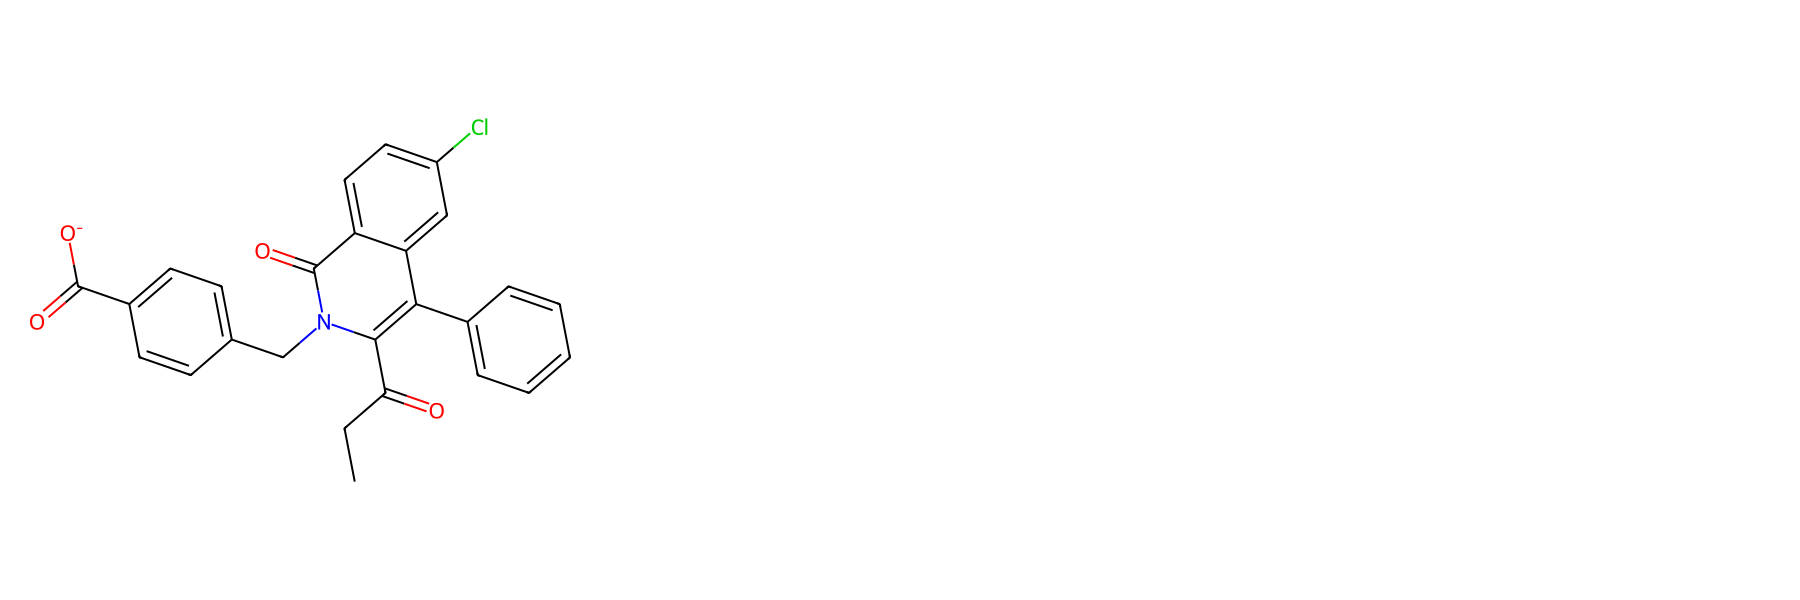

In [5]:
initial_mol = Chem.MolFromMolFile(f"data/docking/{pdb}_ligand.sdf")
initial = Chem.MolToSmiles(initial_mol)

MolsToGridImage([Chem.MolFromSmiles(initial)], subImgSize=(600, 600))

In [6]:
initial

'CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1ccc(C(=O)[O-])cc1'

Obtain Molecular Formula of Initial Ligand

In [7]:
# Convert SMILES to a molecule object
mol = Chem.MolFromSmiles(initial)

# Get the molecular formula
formula = Chem.rdMolDescriptors.CalcMolFormula(mol)

formula

'C26H19ClNO4-'

# Interaction Fingerprints

### Interaction fingerprint for reference molecule

In [8]:
REF_MOL_FILEPATH = f"data/docking/{pdb}_ligand.sdf"
PDB_FILEPATH = f"data/docking/{pdb}.pdb"

fp = plf.Fingerprint()

mol = Chem.MolFromPDBFile(PDB_FILEPATH, removeHs=False)
prot = plf.Molecule(mol)
suppl = plf.sdf_supplier(REF_MOL_FILEPATH)
fp.run_from_iterable(suppl, prot, progress=True)
df_ifp = fp.to_dataframe()
df_ifp.columns = df_ifp.columns.droplevel(0)

  0%|          | 0/1 [00:00<?, ?it/s]

In [9]:
df_ifp

protein        LYS68.A                        ILE70.A    GLY71.A     VAL78.A  \
interaction HBAcceptor Anionic VdWContact Hydrophobic VdWContact Hydrophobic   
Frame                                                                          
0                 True    True       True        True       True        True   

protein                    ALA91.A               ILE124.A  ...   ASN152.A  \
interaction VdWContact Hydrophobic VdWContact Hydrophobic  ... VdWContact   
Frame                                                      ...              
0                 True        True       True        True  ...       True   

protein       SER193.A    VAL196.A               LEU206.A    46C901.A  \
interaction VdWContact Hydrophobic VdWContact Hydrophobic Hydrophobic   
Frame                                                                   
0                 True        True       True        True        True   

protein                             HOH986.A             
interaction PiStacking VdWContact HBAcceptor VdWContact  
Frame                                                    
0                 True       True       True       True  

[1 rows x 28 columns]

### Interaction fingerprint functions

ifp_similarity computes the intersection of IMFs between a generated molecule and a reference fragment

In [10]:
def ifp_similarity(ref_mol_ifp, df_ifp, df):
    ## Rename columns
    df_ifp.columns = [' '.join(col) if isinstance(col, tuple) else col for col in df_ifp.columns]
    ref_mol_ifp.columns = [' '.join(col) if isinstance(col, tuple) else col for col in ref_mol_ifp.columns]
    

    intersections = []
    weighted_intersections = []

    #iterate over the rows
    for index, row in df_ifp.iterrows():
        count=0
        weighted_count = 0
        #iterate over all columns
        for col_name in df_ifp.columns:
            if col_name in ref_mol_ifp.columns and df_ifp[col_name][index]==ref_mol_ifp[col_name][0] and 'VdWContact' in col_name:
                count += 1
                weighted_count += 1
            elif col_name in ref_mol_ifp.columns and df_ifp[col_name][index]==ref_mol_ifp[col_name][0] and 'Hydrophobic' in col_name:
                count += 1
                weighted_count += 2
            elif col_name in ref_mol_ifp.columns and df_ifp[col_name][index]==ref_mol_ifp[col_name][0] and 'HBAcceptor' in col_name:
                count += 1
                weighted_count += 3
            elif col_name in ref_mol_ifp.columns and df_ifp[col_name][index]==ref_mol_ifp[col_name][0] and 'Anionic' in col_name or 'Cationic' in col_name:
                count += 1
                weighted_count += 4
        
        intersections.append(count)
        weighted_intersections.append(weighted_count)
                
    df['IFP Intersection'] = intersections
    df['Weighted IFP Intersection'] = weighted_intersections

    return df


compute_features counts total number of interactions, number of interactions per IMF and weighted number of interactions for generated molecule.

In [11]:
def compute_features(df, ifp):

    cols = ifp.columns

    num_cols = len(ifp.columns)

    data = {'mol_id' : [],
            'num_interactions' : [],
            'weighted_interactions' : [],
            'num_VdW' : [],
            'num_hydrophobic' : [],
            'num_HBAcceptor' : [],
            'num_ionic' : []}

    for index, row in ifp.iterrows():

        weighted_interactions = 0
        num_VdW = 0
        num_hydrophobic = 0
        num_HBAcceptor = 0
        num_ionic = 0
        
        data['mol_id'].append(row['ID'][0])
        data['num_interactions'].append(row[:-1].sum())

        for value in cols:
            
            if value[1] == 'VdWContact':
                weighted_interactions += 1 * row[value]
                num_VdW += 1 * row[value]
            elif value[1] == 'Hydrophobic':
                weighted_interactions += 2 * row[value]
                num_hydrophobic += 1 * row[value]
            elif value[1] == 'HBAcceptor':
                weighted_interactions += 3 * row[value]
                num_HBAcceptor += 1 * row[value]
            elif value[1] == 'Anionic' or value[1] == 'Cationic':
                weighted_interactions += 4 * row[value]
                num_ionic += 1 * row[value]

        data['weighted_interactions'].append(weighted_interactions)
        data['num_VdW'].append(num_VdW)
        data['num_hydrophobic'].append(num_hydrophobic)
        data['num_HBAcceptor'].append(num_HBAcceptor)
        data['num_ionic'].append(num_ionic)

            

    features = pd.DataFrame(data)

    df = df.merge(features[['mol_id', 'num_interactions', 'weighted_interactions', 'num_VdW', 'num_hydrophobic', 'num_HBAcceptor', 'num_ionic']], left_on='ID', right_on='mol_id', how='left')

    df = df.drop(['mol_id'], axis=1).sort_values(['Docking score'], ascending=True)

    df.dropna(axis=0, subset=['Docking score'], inplace=True)
    df['num_interactions'].fillna(0, inplace=True)
    df['weighted_interactions'].fillna(0, inplace=True)

    return df

In [12]:
def visualize_fingerprint(ifp):

    sns.set(rc = {'figure.figsize':(15,8)})
    ax = sns.heatmap(ifp,cmap=sns.cm.rocket_r)
    ax.set_ylabel("Molecule")
    ax.set_xlabel("Protein Interaction")

    return ax

### Handling Duplicates Functions

Function will be used to remove duplicates produced by the same model

In [13]:
def remove_repeats(df, inchi_names):
    """
    Removes rows with repeated 'inchi' and 'Model' values.

    Parameters:
    df (pd.DataFrame): Input DataFrame with columns 'inchi' and 'Model'
    inchi_names (list): List of inchi names to check for repeats

    Returns:
    pd.DataFrame: DataFrame with repeats removed
    """
    # Iterate over each inchi name in inchi_names
    for inchi_name in inchi_names:
        # Get the subset of the DataFrame for the current inchi_name
        df_inchi = df[df['inchi'] == inchi_name]
        
        # Find duplicates based on 'inchi' and 'Model' columns
        duplicates = df_inchi[df_inchi.duplicated(subset=['inchi', 'Model'], keep='first')]
        
        # Drop the duplicate rows from the original DataFrame
        df = df.drop(duplicates.index)
    
    return df

The following functions will be used to identify duplicates across different models

Not all molecules seemed to have a 3D conformers, so we make sure that they do with the ensure 3d conformers

In [14]:
def ensure_3d_conformer(mol):
    """
    Ensure that the RDKit molecule object has a 3D conformation.
    
    Parameters:
    - mol: RDKit molecule object
    
    Returns:
    - mol: RDKit molecule object with a 3D conformation
    """
    if not mol.GetNumConformers():
        # Add hydrogens if not already present
        mol = Chem.AddHs(mol)
        
        # Generate 3D conformation
        result = AllChem.EmbedMolecule(mol)
        if result == -1:  # -1 means embedding failed
            raise ValueError("Failed to generate 3D conformation for the molecule.")
        
        # Optimize the 3D conformation
        AllChem.UFFOptimizeMolecule(mol)
        
    return mol


Following function calculates RMSD between two molecules

In [15]:
def calculate_rmsd(mol1, mol2):
    """
    Calculate RMSD between two RDKit molecule objects with 3D conformations.
    
    Parameters:
    - mol1: RDKit molecule object
    - mol2: RDKit molecule object
    
    Returns:
    - RMSD value (float)
    """
    # Ensure both molecules have 3D conformers
    mol1 = ensure_3d_conformer(mol1)
    mol2 = ensure_3d_conformer(mol2)
    
    if not mol1.GetNumConformers() or not mol2.GetNumConformers():
        raise ValueError("One or both molecules could not be embedded or optimized.")

    # Calculate RMSD
    rms = AllChem.GetBestRMS(mol1, mol2)
    
    return rms


Detect duplicates based on same inchi and RMSD value of less than or equal to 3 (most molecules do and threshold can be adjusted)

In [16]:
#Takes as input an repeated inchi value and returns a dataframe of molecules that have RMSD <=0.3 and their corresponding RoMOL
def duplicate_detector(df):
    
    duplicates_list=[]
    for a,b in itertools.combinations(df.ROMol,2):

        #Calculate average RMSD since it changes at every run
        RMSD_list=[]
        for _ in range(10):
            RMSD = calculate_rmsd(a,b)
            RMSD_list+=[RMSD]
        # Filter out non-numeric values
        RMSD_list = [num for num in RMSD_list if isinstance(num, (int, float))]

        # Calculate the average
        if RMSD_list:
            RMSD_average = sum(RMSD_list) / len(RMSD_list)
        else:
            RMSD_average = None

        rms = RMSD_average

        #Filter at 1 Amstrong
        if rms <=3:
            # Get SMILES String
            mol_a = df[df['ROMol'] == a].iloc[0,0]
            mol_b = df[df['ROMol'] == b].iloc[0,0]
            # Get model
            model_a_index = df[df['ROMol'] == a].index[0]
            model_a= df.at[model_a_index, 'Model']
            
            model_b_index = df[df['ROMol'] == b].index[0]
            model_b= df.at[model_b_index, 'Model']

            #Add ROMol
            duplicates_list.append((mol_a, model_a, a, mol_b, model_b, b, rms))
    column_names = ['Smiles_1', 'model_1', 'ROMol_1', 'Smiles_2', 'model_2', 'ROMol_2', 'Average_RMSD']
    df_new=pd.DataFrame(duplicates_list, columns=column_names)

    return df_new   

Function checks repeated molecules from all of the repeated inchi values in the dataset

In [17]:
#Takes as input dataframe with all data and a list of repeated inchi names and returns a dataframe with duplicates
def process_inchi_names(model_df, inchi_names):
    """Process a list of InChI names and concatenate results."""
    all_results = []
    
    for inchi_name in inchi_names:
        # Filter the DataFrame for the current InChI name
        df_filtered = model_df.query(f'inchi == "{inchi_name}"')
        
        # Apply the duplicate_detector function
        df_duplicates = duplicate_detector(df_filtered)
        
        # Append result if it's not empty
        if not df_duplicates.empty:
            all_results.append(df_duplicates)
    
    # Concatenate all results into a single DataFrame, if there are any
    if all_results:
        final_df = pd.concat(all_results, ignore_index=True)
    else:
        # Return an empty DataFrame with the same columns if no results
        column_names = ['Smiles_1', 'model_1', 'ROMol_1', 'Smiles_2', 'model_2', 'ROMol_2', 'Average_RMSD']
        final_df = pd.DataFrame(columns=column_names)
    
    return final_df


The following function removes generated molecules that have more than one fragment

In [18]:
def remove_broken_molecules(df):

    smiles = df['SMILES'].to_list()

    mols = [Chem.MolFromSmiles(smile) for smile in smiles]

    df['ROMol'] = mols

    df.dropna(subset=['ROMol'], inplace=True)

    df['num_frags'] = df.ROMol.apply(uru.count_fragments)

    df_single_frag = df.query("num_frags == 1").copy()

    return df_single_frag

# Generating Analogs


## REINVENT

In [19]:
model = 'reinvent'

DF_FILEPATH = f'experiments/data/{model}_dataframe.csv'
IFP_FILEPATH = f'experiments/data/{model}_ifp.csv'

df_reinvent = pd.read_csv(DF_FILEPATH, index_col=0)

ifp_reinvent = pd.read_csv(IFP_FILEPATH, header=[0, 1], index_col=0)

FileNotFoundError: [Errno 2] No such file or directory: 'experiments/data/reinvent_dataframe.csv'

Compute metrics

In [30]:
#Compute length to check that no molecules are being filtered by metric computation
len(df_reinvent)

200

In [31]:
#number of IMFs
df_reinvent = compute_features(df_reinvent, ifp_reinvent)
# Compare IMFs to initial fragment
df_reinvent = ifp_similarity(df_ifp, ifp_reinvent, df_reinvent)

df_reinvent.drop(['Input_SMILES', 'Prior', 'Tanimoto'], axis=1, inplace=True)
df_reinvent['Model'] = model


/tmp/ipykernel_27750/2422888854.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data['mol_id'].append(row['ID'][0])
/tmp/ipykernel_27750/2422888854.py:56: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['num_interactions'].fillna(0, inplace=True)
/tmp/ipykernel_27750/2422888854.py:57: FutureWarning: A value is trying to be set on a copy

### Handling Duplicates and Broken Molecules

In [32]:
# Add a column with mol object information for each molecule
df_reinvent['ROMol']=[Chem.MolFromSmiles(x) for x in df_reinvent['SMILES'].values]
df_reinvent['inchi'] = df_reinvent.ROMol.apply(Chem.MolToInchiKey)

# Count repeated InChI
value_counts_reinvent=df_reinvent.inchi.value_counts()
filtered_counts_reinvent = value_counts_reinvent[value_counts_reinvent > 1]

# Get values for InChI
inchi_names_reinvent=filtered_counts_reinvent.index.tolist()
filtered_counts_reinvent


inchi
INTVHXLIMVYQAA-UHFFFAOYSA-N    2
WXBIBKGVBWUZDU-UHFFFAOYSA-N    2
CTCLTOJCNKDHQF-UHFFFAOYSA-N    2
XFWIKQQMAXMEAO-UHFFFAOYSA-N    2
DSYRZOREFKGMPZ-UHFFFAOYSA-N    2
WIXBKMMSTFRRDB-UHFFFAOYSA-N    2
UEECRUKKMUHGSP-UHFFFAOYSA-N    2
ITAZALHTZBIKDO-UHFFFAOYSA-N    2
NLEDKDZIWCOQEU-UHFFFAOYSA-N    2
BLOMDABYOYDSLH-UHFFFAOYSA-N    2
Name: count, dtype: int64

In [33]:
df_reinvent = remove_repeats(df_reinvent, inchi_names_reinvent)
df_reinvent = remove_broken_molecules(df_reinvent)
df_reinvent

,SMILES,ID,Docking score,rmsd,num_interactions,weighted_interactions,num_VdW,num_hydrophobic,num_HBAcceptor,num_ionic,IFP Intersection,Weighted IFP Intersection,Model,ROMol,inchi,num_frags
121,CCOC(=O)c1c(-c2ccccc2)c2cc(C(F)(F)F)ccc2c(=O)n...,MOL0121,-16.624857,3.737471,27,45,13,10,4,0,21,39,reinvent,<rdkit.Chem.rdchem.Mol object at 0x76cf79bb6ff0>,HWIVDTJICOPGOE-UHFFFAOYSA-N,1
196,COCC(=O)/C=C/c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1...,MOL0196,-16.540930,3.676144,32,48,17,11,3,0,24,41,reinvent,<rdkit.Chem.rdchem.Mol object at 0x76cf79bb6260>,NTAOAOHXWHNUIN-WYMLVPIESA-N,1
150,CCC(=O)c1ccc(Cn2c(C(=O)OC)c(-c3ccccc3)c3cc(Cl)...,MOL0150,-16.529593,5.569642,25,40,11,10,3,0,20,36,reinvent,<rdkit.Chem.rdchem.Mol object at 0x76cf79bb5bd0>,VMWOGGBYNAATGR-UHFFFAOYSA-N,1
99,COc1ccc2c(=O)n(Cc3ccc(C(=O)O)cc3)c(/C=C/C(=O)O...,MOL0099,-16.301600,3.785833,29,45,16,10,3,0,22,38,reinvent,<rdkit.Chem.rdchem.Mol object at 0x76cf79bb5700>,YEKWFDWOEIVHCQ-BUHFOSPRSA-N,1
127,CC(=O)c1c(-c2ccccc2)c2cc(C(F)(F)F)ccc2c(=O)n1C...,MOL0127,-16.295380,5.360354,27,42,14,11,2,0,20,35,reinvent,<rdkit.Chem.rdchem.Mol object at 0x76cf79bb4c80>,PBWPETCFSWLAEH-UHFFFAOYSA-N,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,CCC(=O)c1c(-c2ccc(S(C)(=O)=O)cc2)c2cc(Cl)ccc2c...,MOL0074,-11.602587,9.200715,31,47,16,11,3,0,18,31,reinvent,<rdkit.Chem.rdchem.Mol object at 0x76cf79bc1380>,SNOIDCFZEPWWNN-UHFFFAOYSA-N,1
46,CCOc1ccc2c(C(=O)CC)n(Cc3ccc(C(=O)O)cc3)c(=O)c(...,MOL0046,-10.755634,9.745061,31,47,17,12,2,0,19,33,reinvent,<rdkit.Chem.rdchem.Mol object at 0x76cf79bc13f0>,PIEHRRXYYHEKAH-UHFFFAOYSA-N,1
27,CCCCNS(=O)(=O)COc1ccc(Cn2c(C(=O)CC)c(-c3ccccc3...,MOL0027,-10.040281,8.536440,30,45,15,12,2,0,20,35,reinvent,<rdkit.Chem.rdchem.Mol object at 0x76cf79bc1460>,PUGUQWBRPLDHEL-UHFFFAOYSA-N,1
90,COc1ccc2c(C(=O)OC(C)C)n(Cc3ccc(C(=O)O)cc3)c(=O...,MOL0090,-9.814790,8.372586,30,40,19,9,1,0,17,27,reinvent,<rdkit.Chem.rdchem.Mol object at 0x76cf79bc14d0>,LPYJFGGCNULWNI-UHFFFAOYSA-N,1


## CReM

In [34]:
model = 'crem'

DF_FILEPATH = f'experiments/data/{model}_dataframe.csv'
IFP_FILEPATH = f'experiments/data/{model}_ifp.csv'

df_crem = pd.read_csv(DF_FILEPATH, index_col=0)

ifp_crem = pd.read_csv(IFP_FILEPATH, header=[0, 1], index_col=0)

In [35]:
#Compute length to check that no molecules are being filtered by metric computation
len(df_crem), len(ifp_crem)

(200, 200)

Compute metrics

In [36]:
#number of IMFs
df_crem = compute_features(df_crem, ifp_crem)
len(df_crem)

/tmp/ipykernel_27750/2422888854.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data['mol_id'].append(row['ID'][0])
/tmp/ipykernel_27750/2422888854.py:56: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['num_interactions'].fillna(0, inplace=True)
/tmp/ipykernel_27750/2422888854.py:57: FutureWarning: A value is trying to be set on a copy

200

Remark: compute_features drops molecules that are not able to dock, i.e, do not have a docking score

In [37]:
# Compare IMFs to initial fragment
df_crem = ifp_similarity(df_ifp, ifp_crem, df_crem)

In [38]:
df_crem

,SMILES,Model,ID,Docking score,rmsd,num_interactions,weighted_interactions,num_VdW,num_hydrophobic,num_HBAcceptor,num_ionic,IFP Intersection,Weighted IFP Intersection
143,O=C([O-])c1ccc(Cn2c(C(=O)CO)c(-c3ccccc3)c3cc(C...,crem,MOL0143,-17.774439,5.413626,26,46,10,10,4,1,25,49
63,N#[N+][N-]CC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O...,crem,MOL0063,-17.371605,5.259105,27,46,12,9,4,1,25,48
71,CCSCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1c...,crem,MOL0071,-17.015150,5.448202,32,55,15,12,4,1,26,51
92,CN(C)CC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc...,crem,MOL0092,-16.942169,5.410044,28,46,13,10,3,1,24,46
168,O=C([O-])c1ccc(Cn2c(C(=O)O)c(-c3ccccc3)c3cc(Cl...,crem,MOL0168,-16.900478,5.955139,27,46,13,10,3,1,23,45
...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1ccc...,crem,MOL0165,-13.109873,4.764589,29,44,16,11,2,0,24,42
20,CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1ccc...,crem,MOL0020,-12.986256,7.095790,29,44,16,11,2,0,24,42
70,CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1ccc...,crem,MOL0070,-12.891748,7.671322,27,39,16,10,1,0,21,36
19,CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1ccc...,crem,MOL0019,-12.490393,6.543430,26,41,13,11,2,0,22,40


### Handling Duplicates and Broken Molecules

In [39]:
# Add a column with mol object information for each molecule
df_crem['ROMol']=[Chem.MolFromSmiles(x) for x in df_crem['SMILES'].values]
df_crem['inchi'] = df_crem.ROMol.apply(Chem.MolToInchiKey)

# Count repeated InChI
value_counts_crem=df_crem.inchi.value_counts()
filtered_counts_crem = value_counts_crem[value_counts_crem > 1]

# Get values for InChI
inchi_names_crem=filtered_counts_crem.index.tolist()
filtered_counts_crem


Series([], Name: count, dtype: int64)

In [40]:
df_crem=remove_repeats(df_crem, inchi_names_crem)
df_crem= remove_broken_molecules(df_crem)
df_crem

,SMILES,Model,ID,Docking score,rmsd,num_interactions,weighted_interactions,num_VdW,num_hydrophobic,num_HBAcceptor,num_ionic,IFP Intersection,Weighted IFP Intersection,ROMol,inchi,num_frags
143,O=C([O-])c1ccc(Cn2c(C(=O)CO)c(-c3ccccc3)c3cc(C...,crem,MOL0143,-17.774439,5.413626,26,46,10,10,4,1,25,49,<rdkit.Chem.rdchem.Mol object at 0x76cf79be35a0>,PLJJGRLXKRXUFN-UHFFFAOYSA-M,1
63,N#[N+][N-]CC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O...,crem,MOL0063,-17.371605,5.259105,27,46,12,9,4,1,25,48,<rdkit.Chem.rdchem.Mol object at 0x76cf79be3610>,WHRNKUHDPIFIMK-UHFFFAOYSA-M,1
71,CCSCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1c...,crem,MOL0071,-17.015150,5.448202,32,55,15,12,4,1,26,51,<rdkit.Chem.rdchem.Mol object at 0x76cf79be3680>,MKWLLKRQSVLPFW-UHFFFAOYSA-M,1
92,CN(C)CC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc...,crem,MOL0092,-16.942169,5.410044,28,46,13,10,3,1,24,46,<rdkit.Chem.rdchem.Mol object at 0x76cf79be36f0>,HJELBXYVPQZBSZ-UHFFFAOYSA-M,1
168,O=C([O-])c1ccc(Cn2c(C(=O)O)c(-c3ccccc3)c3cc(Cl...,crem,MOL0168,-16.900478,5.955139,27,46,13,10,3,1,23,45,<rdkit.Chem.rdchem.Mol object at 0x76cf79be3760>,DTXLARLYQWAPBA-UHFFFAOYSA-M,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1ccc...,crem,MOL0165,-13.109873,4.764589,29,44,16,11,2,0,24,42,<rdkit.Chem.rdchem.Mol object at 0x76cf79be8c10>,OWKJKUZLPISEKE-UHFFFAOYSA-N,1
20,CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1ccc...,crem,MOL0020,-12.986256,7.095790,29,44,16,11,2,0,24,42,<rdkit.Chem.rdchem.Mol object at 0x76cf79be8c80>,ZTFFKHHKYJULCY-UHFFFAOYSA-N,1
70,CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1ccc...,crem,MOL0070,-12.891748,7.671322,27,39,16,10,1,0,21,36,<rdkit.Chem.rdchem.Mol object at 0x76cf79be8cf0>,JDZHQQSBMFYWJB-UHFFFAOYSA-N,1
19,CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1ccc...,crem,MOL0019,-12.490393,6.543430,26,41,13,11,2,0,22,40,<rdkit.Chem.rdchem.Mol object at 0x76cf79be8d60>,MHOTUCRYYXYZKN-UHFFFAOYSA-N,1


Create dataframe that contains all generated molecules

In [41]:
model_df = pd.concat((df_reinvent, df_crem))


## Coati

In [42]:
model = 'coati'

DF_FILEPATH = f'experiments/data/{model}_dataframe.csv'
IFP_FILEPATH = f'experiments/data/{model}_ifp.csv'

df_coati = pd.read_csv(DF_FILEPATH, index_col=0)

ifp_coati = pd.read_csv(IFP_FILEPATH, header=[0, 1], index_col=0)

Compute metrics

In [43]:
#number of IMFs
df_coati = compute_features(df_coati, ifp_coati)
df_coati = ifp_similarity(df_ifp, ifp_coati, df_coati)

/tmp/ipykernel_27750/2422888854.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data['mol_id'].append(row['ID'][0])
/tmp/ipykernel_27750/2422888854.py:56: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['num_interactions'].fillna(0, inplace=True)
/tmp/ipykernel_27750/2422888854.py:57: FutureWarning: A value is trying to be set on a copy

In [44]:
#Visualize df_coati
df_coati

,SMILES,Model,ID,Docking score,rmsd,num_interactions,weighted_interactions,num_VdW,num_hydrophobic,num_HBAcceptor,num_ionic,IFP Intersection,Weighted IFP Intersection
115,CC[N-]C(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc...,coati,MOL0115,-17.443041,5.418772,28.0,49.0,13.0,10.0,4.0,1.0,25,49
4,CCc1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1ccc(C(=O...,coati,MOL0004,-17.416050,5.620918,25.0,42.0,12.0,10.0,2.0,1.0,21,41
177,CCc1c(-c2ccccc2F)c2cc(Cl)ccc2c(=O)n1Cc1ccc(C(=...,coati,MOL0177,-16.959734,7.243289,28.0,48.0,13.0,11.0,3.0,1.0,26,49
86,CC/C=C(\[O-])c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1...,coati,MOL0086,-16.932600,5.345138,28.0,49.0,13.0,10.0,4.0,1.0,24,48
187,CCC(=O)C(=Cc1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc...,coati,MOL0187,-16.932457,5.265909,27.0,47.0,12.0,11.0,3.0,1.0,26,49
...,...,...,...,...,...,...,...,...,...,...,...,...,...
188,CCC(=O)C(=C1C=C(Cl)C(=O)c2ccccc2N1Cc1ccc(C(=O)...,coati,MOL0188,-5.487673,13.214549,28.0,40.0,17.0,8.0,1.0,1.0,18,34
71,CCC([O-])c1ccc(-c2ccccc2)c(=O)c2cc(Cl)c-2n1Cc1...,coati,MOL0071,-4.241667,35.796951,29.0,41.0,19.0,8.0,2.0,0.0,16,29
23,CCC(=O)C(=CC1=CC=C(c2ccccc2)c2cc(Cl)ccc2N1Cc1c...,coati,MOL0023,-3.830249,21.250964,33.0,45.0,19.0,13.0,0.0,0.0,18,30
104,CCC(=O)c1c(-c2ccccc2)n(Cc2c(C(=O)[O-])ccc(F)c2...,coati,MOL0104,-3.757418,30.785659,26.0,36.0,15.0,9.0,1.0,0.0,19,33


### Handling Duplicates and Broken Molecules

In [45]:
# Add a column with mol object information for each molecule
df_coati['ROMol']=[Chem.MolFromSmiles(x) for x in df_coati['SMILES'].values]
df_coati['inchi'] = df_coati.ROMol.apply(Chem.MolToInchiKey)

# Count repeated InChI
value_counts_coati=df_coati.inchi.value_counts()
filtered_counts_coati = value_counts_coati[value_counts_coati > 1]

#Get values of InChi
inchi_names_coati=filtered_counts_coati.index.tolist()
filtered_counts_coati


Series([], Name: count, dtype: int64)

In [46]:
df_coati = remove_repeats(df_coati, inchi_names_coati)
df_coati = remove_broken_molecules(df_coati)

In [47]:
model_df = pd.concat((model_df, df_coati))

In [71]:
model_df

,SMILES,ID,Docking score,rmsd,num_interactions,weighted_interactions,num_VdW,num_hydrophobic,num_HBAcceptor,num_ionic,IFP Intersection,Weighted IFP Intersection,Model,ROMol,inchi,num_frags
121,CCOC(=O)c1c(-c2ccccc2)c2cc(C(F)(F)F)ccc2c(=O)n...,MOL0121,-16.624857,3.737471,27.0,45.0,13.0,10.0,4.0,0.0,21,39,reinvent,<rdkit.Chem.rdchem.Mol object at 0x76cf79bb6ff0>,HWIVDTJICOPGOE-UHFFFAOYSA-N,1
196,COCC(=O)/C=C/c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1...,MOL0196,-16.540930,3.676144,32.0,48.0,17.0,11.0,3.0,0.0,24,41,reinvent,<rdkit.Chem.rdchem.Mol object at 0x76cf79bb6260>,NTAOAOHXWHNUIN-WYMLVPIESA-N,1
150,CCC(=O)c1ccc(Cn2c(C(=O)OC)c(-c3ccccc3)c3cc(Cl)...,MOL0150,-16.529593,5.569642,25.0,40.0,11.0,10.0,3.0,0.0,20,36,reinvent,<rdkit.Chem.rdchem.Mol object at 0x76cf79bb5bd0>,VMWOGGBYNAATGR-UHFFFAOYSA-N,1
99,COc1ccc2c(=O)n(Cc3ccc(C(=O)O)cc3)c(/C=C/C(=O)O...,MOL0099,-16.301600,3.785833,29.0,45.0,16.0,10.0,3.0,0.0,22,38,reinvent,<rdkit.Chem.rdchem.Mol object at 0x76cf79bb5700>,YEKWFDWOEIVHCQ-BUHFOSPRSA-N,1
127,CC(=O)c1c(-c2ccccc2)c2cc(C(F)(F)F)ccc2c(=O)n1C...,MOL0127,-16.295380,5.360354,27.0,42.0,14.0,11.0,2.0,0.0,20,35,reinvent,<rdkit.Chem.rdchem.Mol object at 0x76cf79bb4c80>,PBWPETCFSWLAEH-UHFFFAOYSA-N,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188,CCC(=O)C(=C1C=C(Cl)C(=O)c2ccccc2N1Cc1ccc(C(=O)...,MOL0188,-5.487673,13.214549,28.0,40.0,17.0,8.0,1.0,1.0,18,34,coati,<rdkit.Chem.rdchem.Mol object at 0x76cf79a06880>,USTKVRWWWXGQGP-UHFFFAOYSA-M,1
71,CCC([O-])c1ccc(-c2ccccc2)c(=O)c2cc(Cl)c-2n1Cc1...,MOL0071,-4.241667,35.796951,29.0,41.0,19.0,8.0,2.0,0.0,16,29,coati,<rdkit.Chem.rdchem.Mol object at 0x76cf79a068f0>,IBVSDAOTFCUSRY-UHFFFAOYSA-M,1
23,CCC(=O)C(=CC1=CC=C(c2ccccc2)c2cc(Cl)ccc2N1Cc1c...,MOL0023,-3.830249,21.250964,33.0,45.0,19.0,13.0,0.0,0.0,18,30,coati,<rdkit.Chem.rdchem.Mol object at 0x76cf79a06960>,SUFSRUHCFDXOJS-UHFFFAOYSA-M,1
104,CCC(=O)c1c(-c2ccccc2)n(Cc2c(C(=O)[O-])ccc(F)c2...,MOL0104,-3.757418,30.785659,26.0,36.0,15.0,9.0,1.0,0.0,19,33,coati,<rdkit.Chem.rdchem.Mol object at 0x76cf79a069d0>,GLOULCYIYBIWFV-UHFFFAOYSA-L,1


## SAFE

In [64]:
model = 'safe'

DF_FILEPATH = f'experiments/data/{model}_dataframe.csv'
IFP_FILEPATH = f'data/{model}_ifp.csv'


df_safe = pd.read_csv(DF_FILEPATH, index_col=0)

ifp_safe = pd.read_csv(IFP_FILEPATH, header=[0, 1], index_col=0)

FileNotFoundError: [Errno 2] No such file or directory: 'data/safe_ifp.csv'

Compute metrics

In [50]:
#Compute IMFs
df_safe = compute_features(df_safe, ifp_safe)
#Compare IMFs of reference molecule
df_safe = ifp_similarity(df_ifp, ifp_safe, df_safe)

NameError: name 'df_safe' is not defined

In [43]:
#visualize df
df_safe

,SMILES,Model,ID,Docking score,rmsd,num_interactions,weighted_interactions,num_VdW,num_hydrophobic,num_HBAcceptor,num_ionic,IFP Intersection,Weighted IFP Intersection
47,O=C([O-])c1ccc(Cn2c(C(=O)CCC3CC3)c(-c3ccccc3)c...,safe,MOL0047,-15.601217,7.908458,30.0,49.0,15.0,12.0,2.0,1.0,23,44
85,C1=CCCC=C1.O=C([O-])c1ccc(Cn2c(C(=O)CCC3CC3)c(...,safe,MOL0085,-15.601217,7.908458,30.0,49.0,15.0,12.0,2.0,1.0,23,44
1,O=C([O-])c1ccc(Cn2c(C(=O)CCc3nn[nH]n3)c(-c3ccc...,safe,MOL0001,-15.532927,4.388540,27.0,45.0,13.0,11.0,2.0,1.0,23,44
102,O=C([O-])c1ccc(Cn2c(C(=O)CCc3nn[nH]n3)c(-c3ccc...,safe,MOL0102,-15.532927,4.388540,27.0,45.0,13.0,11.0,2.0,1.0,23,44
39,O=C([O-])c1ccc(Cn2c(C(=O)CCC3CCCC3)c(-c3ccccc3...,safe,MOL0039,-15.505859,4.291146,28.0,48.0,13.0,11.0,3.0,1.0,25,48
...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,O=C([O-])c1ccc(C(c2cccnc2)n2c(C(=O)CCc3nccs3)c...,safe,MOL0116,-6.331114,27.607474,32.0,48.0,17.0,12.0,1.0,1.0,21,39
52,O=C([O-])c1ccc(C(N2CCCCCC2)n2c(C(=O)CCc3ccccc3...,safe,MOL0052,-4.646422,10.012813,33.0,52.0,18.0,12.0,2.0,1.0,23,42
127,O=C([O-])c1ccc(C(c2ccoc2)n2c(C(=O)CCc3nn[nH]n3...,safe,MOL0127,-4.419723,27.196813,29.0,43.0,16.0,10.0,1.0,1.0,20,37
160,O=C([O-])c1ccc(C(c2ncco2)n2c(C(=O)CCc3cccs3)c(...,safe,MOL0160,-3.819107,28.181917,33.0,46.0,22.0,10.0,0.0,1.0,22,38


### Handling Duplicates and Broken Molecules

In [44]:
# Add a column with mol object information for each molecule
df_safe['ROMol']=[Chem.MolFromSmiles(x) for x in df_safe['SMILES'].values]
df_safe['inchi'] = df_safe.ROMol.apply(Chem.MolToInchiKey)

# Count repeated InChI
value_counts_safe=df_safe.inchi.value_counts()
filtered_counts_safe = value_counts_safe[value_counts_safe > 1]

# Get values for InChI
inchi_names_safe=filtered_counts_safe.index.tolist()



In [48]:
df_safe = remove_repeats(df_safe, inchi_names_safe)
df_safe = remove_broken_molecules(df_safe)

In [49]:
len(df_safe)

91

In [50]:
model_df = pd.concat((model_df, df_safe))

In [51]:
model_df

,SMILES,ID,Docking score,rmsd,num_interactions,weighted_interactions,num_VdW,num_hydrophobic,num_HBAcceptor,num_ionic,IFP Intersection,Weighted IFP Intersection,Model,ROMol,inchi,num_frags
121,CCOC(=O)c1c(-c2ccccc2)c2cc(C(F)(F)F)ccc2c(=O)n...,MOL0121,-16.624857,3.737471,27.0,45.0,13.0,10.0,4.0,0.0,21,39,reinvent,<rdkit.Chem.rdchem.Mol object at 0x7e84c1d96ff0>,HWIVDTJICOPGOE-UHFFFAOYSA-N,1
196,COCC(=O)/C=C/c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1...,MOL0196,-16.540930,3.676144,32.0,48.0,17.0,11.0,3.0,0.0,24,41,reinvent,<rdkit.Chem.rdchem.Mol object at 0x7e84c1d96960>,NTAOAOHXWHNUIN-WYMLVPIESA-N,1
150,CCC(=O)c1ccc(Cn2c(C(=O)OC)c(-c3ccccc3)c3cc(Cl)...,MOL0150,-16.529593,5.569642,25.0,40.0,11.0,10.0,3.0,0.0,20,36,reinvent,<rdkit.Chem.rdchem.Mol object at 0x7e84c1d96490>,VMWOGGBYNAATGR-UHFFFAOYSA-N,1
99,COc1ccc2c(=O)n(Cc3ccc(C(=O)O)cc3)c(/C=C/C(=O)O...,MOL0099,-16.301600,3.785833,29.0,45.0,16.0,10.0,3.0,0.0,22,38,reinvent,<rdkit.Chem.rdchem.Mol object at 0x7e84c1d95a80>,YEKWFDWOEIVHCQ-BUHFOSPRSA-N,1
127,CC(=O)c1c(-c2ccccc2)c2cc(C(F)(F)F)ccc2c(=O)n1C...,MOL0127,-16.295380,5.360354,27.0,42.0,14.0,11.0,2.0,0.0,20,35,reinvent,<rdkit.Chem.rdchem.Mol object at 0x7e84c1d957e0>,PBWPETCFSWLAEH-UHFFFAOYSA-N,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,O=C([O-])c1ccc(C(c2cccnc2)n2c(C(=O)CCc3nccs3)c...,MOL0116,-6.331114,27.607474,32.0,48.0,17.0,12.0,1.0,1.0,21,39,safe,<rdkit.Chem.rdchem.Mol object at 0x7e84c1c56ea0>,ZCYGVGRMLSDDFF-UHFFFAOYSA-M,1
52,O=C([O-])c1ccc(C(N2CCCCCC2)n2c(C(=O)CCc3ccccc3...,MOL0052,-4.646422,10.012813,33.0,52.0,18.0,12.0,2.0,1.0,23,42,safe,<rdkit.Chem.rdchem.Mol object at 0x7e84c1c56f10>,DZUQTVKWQPNIOC-UHFFFAOYSA-M,1
127,O=C([O-])c1ccc(C(c2ccoc2)n2c(C(=O)CCc3nn[nH]n3...,MOL0127,-4.419723,27.196813,29.0,43.0,16.0,10.0,1.0,1.0,20,37,safe,<rdkit.Chem.rdchem.Mol object at 0x7e84c1c56f80>,IUKFCOKNBSDBAK-UHFFFAOYSA-M,1
160,O=C([O-])c1ccc(C(c2ncco2)n2c(C(=O)CCc3cccs3)c(...,MOL0160,-3.819107,28.181917,33.0,46.0,22.0,10.0,0.0,1.0,22,38,safe,<rdkit.Chem.rdchem.Mol object at 0x7e84c1c56ff0>,LREBHNMJLUUZQU-UHFFFAOYSA-M,1


# Evaluating Metrics with MolScore

In [68]:
from molscore import MolScore

In [71]:
smiles = model_df['SMILES'].to_list()

In [72]:
ms = MolScore(model_name='mol2mol', task_config='molscore/feature_selection.json')

scores = ms.score(smiles)

Found existing directory, appending current time to distinguish


Found existing rascore-env
Launching server: conda run -n rascore-env python /home/fts_g_ucla_edu/.local/lib/python3.10/site-packages/molscore/scoring_functions/servers/rascore_server.py --port 8001 --model_path /home/fts_g_ucla_edu/.local/lib/python3.10/site-packages/molscore/data/models/RAScore/XGB_chembl_ecfp_counts/model.pkl


In [67]:
file_path = 'experiments/data/goodness_scoring_data/2024_08_07_mol2mol_feature_selection_18_21_40/iterations/000001_scores.csv'  

molscore_df = pd.read_csv(file_path, index_col=0)

FileNotFoundError: [Errno 2] No such file or directory: 'experiments/data/goodness_scoring_data/2024_08_07_mol2mol_feature_selection_18_21_40/iterations/000001_scores.csv'

In [53]:
molscore_df

,model,task,step,batch_idx,absolute_time,smiles,valid,valid_score,unique,occurrences,...,desc_FlourineCount,tanimoto_Sim,tanimoto_Cmpd1_Sim,dice_Sim,dice_Cmpd1_Sim,RAScore_pred_proba,raw_valid_score,amean,filter,score_time
0,mol2mol,feature_selection,1,0,2.996212,CCOC(=O)c1c(-c2ccccc2)c2cc(C(F)(F)F)ccc2c(=O)n...,True,1,True,0,...,3,0.514286,0.514286,0.679245,0.679245,0.982867,1,1.0,1.0,7.704227
1,mol2mol,feature_selection,1,1,2.996212,COCC(=O)/C=C/c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1...,True,1,True,0,...,0,0.521127,0.521127,0.685185,0.685185,0.948534,1,1.0,1.0,7.704227
2,mol2mol,feature_selection,1,2,2.996212,CCC(=O)c1ccc(Cn2c(C(=O)OC)c(-c3ccccc3)c3cc(Cl)...,True,1,True,0,...,0,0.733333,0.733333,0.846154,0.846154,0.910709,1,1.0,1.0,7.704227
3,mol2mol,feature_selection,1,3,2.996212,COc1ccc2c(=O)n(Cc3ccc(C(=O)O)cc3)c(/C=C/C(=O)O...,True,1,True,0,...,0,0.438356,0.438356,0.609524,0.609524,0.945486,1,1.0,1.0,7.704227
4,mol2mol,feature_selection,1,4,2.996212,CC(=O)c1c(-c2ccccc2)c2cc(C(F)(F)F)ccc2c(=O)n1C...,True,1,True,0,...,3,0.522388,0.522388,0.686275,0.686275,0.957991,1,1.0,1.0,7.704227
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
669,mol2mol,feature_selection,1,669,2.996212,O=C([O-])c1ccc(C(c2cccnc2)n2c(C(=O)CCc3nccs3)c...,True,1,True,0,...,0,0.441860,0.441860,0.612903,0.612903,0.286142,1,1.0,1.0,7.704227
670,mol2mol,feature_selection,1,670,2.996212,O=C([O-])c1ccc(C(N2CCCCCC2)n2c(C(=O)CCc3ccccc3...,True,1,True,0,...,0,0.540541,0.540541,0.701754,0.701754,0.817786,1,1.0,1.0,7.704227
671,mol2mol,feature_selection,1,671,2.996212,O=C([O-])c1ccc(C(c2ccoc2)n2c(C(=O)CCc3nn[nH]n3...,True,1,True,0,...,0,0.436782,0.436782,0.608000,0.608000,0.431162,1,1.0,1.0,7.704227
672,mol2mol,feature_selection,1,672,2.996212,O=C([O-])c1ccc(C(c2ncco2)n2c(C(=O)CCc3cccs3)c(...,True,1,True,0,...,0,0.350515,0.350515,0.519084,0.519084,0.709361,1,1.0,1.0,7.704227


# Correlation Analysis

## Set up

Remark: even though the indexes in model_df and df do not match, the information in each row does match

In [54]:
model_df

,SMILES,ID,Docking score,rmsd,num_interactions,weighted_interactions,num_VdW,num_hydrophobic,num_HBAcceptor,num_ionic,IFP Intersection,Weighted IFP Intersection,Model,ROMol,inchi,num_frags
121,CCOC(=O)c1c(-c2ccccc2)c2cc(C(F)(F)F)ccc2c(=O)n...,MOL0121,-16.624857,3.737471,27.0,45.0,13.0,10.0,4.0,0.0,21,39,reinvent,<rdkit.Chem.rdchem.Mol object at 0x7e84c1d96ff0>,HWIVDTJICOPGOE-UHFFFAOYSA-N,1
196,COCC(=O)/C=C/c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1...,MOL0196,-16.540930,3.676144,32.0,48.0,17.0,11.0,3.0,0.0,24,41,reinvent,<rdkit.Chem.rdchem.Mol object at 0x7e84c1d96960>,NTAOAOHXWHNUIN-WYMLVPIESA-N,1
150,CCC(=O)c1ccc(Cn2c(C(=O)OC)c(-c3ccccc3)c3cc(Cl)...,MOL0150,-16.529593,5.569642,25.0,40.0,11.0,10.0,3.0,0.0,20,36,reinvent,<rdkit.Chem.rdchem.Mol object at 0x7e84c1d96490>,VMWOGGBYNAATGR-UHFFFAOYSA-N,1
99,COc1ccc2c(=O)n(Cc3ccc(C(=O)O)cc3)c(/C=C/C(=O)O...,MOL0099,-16.301600,3.785833,29.0,45.0,16.0,10.0,3.0,0.0,22,38,reinvent,<rdkit.Chem.rdchem.Mol object at 0x7e84c1d95a80>,YEKWFDWOEIVHCQ-BUHFOSPRSA-N,1
127,CC(=O)c1c(-c2ccccc2)c2cc(C(F)(F)F)ccc2c(=O)n1C...,MOL0127,-16.295380,5.360354,27.0,42.0,14.0,11.0,2.0,0.0,20,35,reinvent,<rdkit.Chem.rdchem.Mol object at 0x7e84c1d957e0>,PBWPETCFSWLAEH-UHFFFAOYSA-N,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,O=C([O-])c1ccc(C(c2cccnc2)n2c(C(=O)CCc3nccs3)c...,MOL0116,-6.331114,27.607474,32.0,48.0,17.0,12.0,1.0,1.0,21,39,safe,<rdkit.Chem.rdchem.Mol object at 0x7e84c1c56ea0>,ZCYGVGRMLSDDFF-UHFFFAOYSA-M,1
52,O=C([O-])c1ccc(C(N2CCCCCC2)n2c(C(=O)CCc3ccccc3...,MOL0052,-4.646422,10.012813,33.0,52.0,18.0,12.0,2.0,1.0,23,42,safe,<rdkit.Chem.rdchem.Mol object at 0x7e84c1c56f10>,DZUQTVKWQPNIOC-UHFFFAOYSA-M,1
127,O=C([O-])c1ccc(C(c2ccoc2)n2c(C(=O)CCc3nn[nH]n3...,MOL0127,-4.419723,27.196813,29.0,43.0,16.0,10.0,1.0,1.0,20,37,safe,<rdkit.Chem.rdchem.Mol object at 0x7e84c1c56f80>,IUKFCOKNBSDBAK-UHFFFAOYSA-M,1
160,O=C([O-])c1ccc(C(c2ncco2)n2c(C(=O)CCc3cccs3)c(...,MOL0160,-3.819107,28.181917,33.0,46.0,22.0,10.0,0.0,1.0,22,38,safe,<rdkit.Chem.rdchem.Mol object at 0x7e84c1c56ff0>,LREBHNMJLUUZQU-UHFFFAOYSA-M,1


In [55]:
molscore_df

,model,task,step,batch_idx,absolute_time,smiles,valid,valid_score,unique,occurrences,...,desc_FlourineCount,tanimoto_Sim,tanimoto_Cmpd1_Sim,dice_Sim,dice_Cmpd1_Sim,RAScore_pred_proba,raw_valid_score,amean,filter,score_time
0,mol2mol,feature_selection,1,0,2.996212,CCOC(=O)c1c(-c2ccccc2)c2cc(C(F)(F)F)ccc2c(=O)n...,True,1,True,0,...,3,0.514286,0.514286,0.679245,0.679245,0.982867,1,1.0,1.0,7.704227
1,mol2mol,feature_selection,1,1,2.996212,COCC(=O)/C=C/c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1...,True,1,True,0,...,0,0.521127,0.521127,0.685185,0.685185,0.948534,1,1.0,1.0,7.704227
2,mol2mol,feature_selection,1,2,2.996212,CCC(=O)c1ccc(Cn2c(C(=O)OC)c(-c3ccccc3)c3cc(Cl)...,True,1,True,0,...,0,0.733333,0.733333,0.846154,0.846154,0.910709,1,1.0,1.0,7.704227
3,mol2mol,feature_selection,1,3,2.996212,COc1ccc2c(=O)n(Cc3ccc(C(=O)O)cc3)c(/C=C/C(=O)O...,True,1,True,0,...,0,0.438356,0.438356,0.609524,0.609524,0.945486,1,1.0,1.0,7.704227
4,mol2mol,feature_selection,1,4,2.996212,CC(=O)c1c(-c2ccccc2)c2cc(C(F)(F)F)ccc2c(=O)n1C...,True,1,True,0,...,3,0.522388,0.522388,0.686275,0.686275,0.957991,1,1.0,1.0,7.704227
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
669,mol2mol,feature_selection,1,669,2.996212,O=C([O-])c1ccc(C(c2cccnc2)n2c(C(=O)CCc3nccs3)c...,True,1,True,0,...,0,0.441860,0.441860,0.612903,0.612903,0.286142,1,1.0,1.0,7.704227
670,mol2mol,feature_selection,1,670,2.996212,O=C([O-])c1ccc(C(N2CCCCCC2)n2c(C(=O)CCc3ccccc3...,True,1,True,0,...,0,0.540541,0.540541,0.701754,0.701754,0.817786,1,1.0,1.0,7.704227
671,mol2mol,feature_selection,1,671,2.996212,O=C([O-])c1ccc(C(c2ccoc2)n2c(C(=O)CCc3nn[nH]n3...,True,1,True,0,...,0,0.436782,0.436782,0.608000,0.608000,0.431162,1,1.0,1.0,7.704227
672,mol2mol,feature_selection,1,672,2.996212,O=C([O-])c1ccc(C(c2ncco2)n2c(C(=O)CCc3cccs3)c(...,True,1,True,0,...,0,0.350515,0.350515,0.519084,0.519084,0.709361,1,1.0,1.0,7.704227


### Creating features dataframe

Define $X$

In [56]:
# drop categorical features and redudant features

# Got rid of SA score and desc_PenLogP  because all entries are zero
# Got rid of QED as in ecompasses several other features

X = molscore_df.drop(['smiles', 'model', 'task', 'step',
            'batch_idx', 'absolute_time',
            'valid', 'valid_score', 'unique',
            'occurrences','dice_Cmpd1_Sim', 'tanimoto_Cmpd1_Sim', 
            'amean', 'filter',
            'score_time', 'raw_valid_score','desc_MolecularFormula', 'desc_SAscore', 'desc_PenLogP', 'desc_QED'], axis=1)

Adding new features

In [57]:
X['ifp_intersection']=model_df['IFP Intersection'].values 
X['Docking score'] = model_df['Docking score'].values
X['num_interactions'] = model_df['num_interactions'].values

In [58]:
# weighted_ifp_intersection = model_df['Weighted IFP Intersection'].values
# X['ifp_intersection']=model_df['IFP Intersection'].values 
# X['Weighted IFP Similarity'] = weighted_ifp_intersection / model_df['weighted_interactions'].values
# X['IFP Similarity'] = weighted_ifp_intersection / model_df['weighted_interactions'].values
# X['Docking score'] = model_df['Docking score'].values
# X['num_interactions'] = model_df['num_interactions'].values
# X['weighted_interactions'] = model_df['weighted_interactions'].values
# X['Interaction Weight Ratio'] = model_df['weighted_interactions'].values / model_df['num_interactions'].values

Renaming features

In [59]:
molscore_df.columns

Index(['model', 'task', 'step', 'batch_idx', 'absolute_time', 'smiles',
       'valid', 'valid_score', 'unique', 'occurrences', 'desc_QED',
       'desc_SAscore', 'desc_CLogP', 'desc_MolWt', 'desc_HeavyAtomCount',
       'desc_HeavyAtomMolWt', 'desc_NumHAcceptors', 'desc_NumHDonors',
       'desc_NumHeteroatoms', 'desc_NumRotatableBonds',
       'desc_NumAromaticRings', 'desc_NumAliphaticRings', 'desc_RingCount',
       'desc_TPSA', 'desc_PenLogP', 'desc_FormalCharge',
       'desc_MolecularFormula', 'desc_Bertz',
       'desc_MaxConsecutiveRotatableBonds', 'desc_FlourineCount',
       'tanimoto_Sim', 'tanimoto_Cmpd1_Sim', 'dice_Sim', 'dice_Cmpd1_Sim',
       'RAScore_pred_proba', 'raw_valid_score', 'amean', 'filter',
       'score_time'],
      dtype='object')

In [60]:
column_names = {
    'desc_Bertz' : 'Synthetic Complexity',
    'interaction weight ratio' : 'Avg Interaction Strength',
    'Weighted IFP Similarity' : 'Weighted Interaction Similarity',
    'RAScore_pred_proba' : 'Synthetic Accessibility',
    'desc_NumHeteroatoms' : '# Heteroatoms',
    'desc_HeavyAtomMolWt': "Heavy Atom MolWt", 
    'desc_NumHAcceptors': '# HAcceptors', 
    'desc_NumHDonors':"#HDonors",
    'desc_NumRotatableBonds': '# Rotatable Bonds',
    'desc_NumAromaticRings': '# Aromatic Rings', 
    'desc_NumAliphaticRings': 'Number Aliphatic Rings', 
    'desc_RingCount': 'Ring Count',
    'desc_TPSA': 'TPSA', 
    'desc_FormalCharge': 'Formal Charge',
    'desc_CLogP': 'CLogP',
    'desc_MolWt': 'MolWt', 
    'desc_HeavyAtomCount': 'Heavy Atom Count',
    'desc_MaxConsecutiveRotatableBonds': 'Max Consecutive Rotatable Bonds',
    'tanimoto_Sim': 'Tanimoto Sim',
    'dice_Sim': 'Dice Sim',
    'desc_FlourineCount':'Fluorine Count'
    }

X.rename(columns=column_names, inplace=True)

In [61]:
X

,CLogP,MolWt,Heavy Atom Count,Heavy Atom MolWt,# HAcceptors,#HDonors,# Heteroatoms,# Rotatable Bonds,# Aromatic Rings,Number Aliphatic Rings,...,Formal Charge,Synthetic Complexity,Max Consecutive Rotatable Bonds,Fluorine Count,Tanimoto Sim,Dice Sim,Synthetic Accessibility,ifp_intersection,Docking score,num_interactions
0,5.6105,495.453,36,475.293,5,1,9,6,4,0,...,0,1507.458087,2,3,0.514286,0.679245,0.982867,21,-16.624857,27.0
1,5.2971,487.939,35,465.763,5,1,7,8,4,0,...,0,1488.314380,3,0,0.521127,0.685185,0.948534,24,-16.540930,32.0
2,5.7495,459.929,33,437.753,5,0,6,6,4,0,...,0,1406.508497,2,0,0.733333,0.846154,0.910709,20,-16.529593,25.0
3,4.5214,455.466,34,434.298,5,2,7,7,4,0,...,0,1467.520115,2,0,0.438356,0.609524,0.945486,22,-16.301600,29.0
4,5.6364,465.427,34,447.283,4,1,8,5,4,0,...,0,1470.935757,2,3,0.522388,0.686275,0.957991,20,-16.295380,27.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
669,5.9901,605.095,43,581.911,8,0,9,9,6,0,...,-1,1992.396139,4,0,0.441860,0.612903,0.286142,21,-6.331114,32.0
670,6.9238,618.153,45,583.881,6,0,7,9,5,1,...,-1,1877.623613,4,0,0.540541,0.701754,0.817786,23,-4.646422,33.0
671,4.2447,578.992,42,557.824,9,1,11,9,6,0,...,-1,1952.020640,4,0,0.436782,0.608000,0.431162,20,-4.419723,29.0
672,7.9166,676.195,47,652.003,9,0,10,10,7,0,...,-1,2277.860438,4,0,0.350515,0.519084,0.709361,22,-3.819107,33.0


Save X df for animation

In [62]:
# Save DataFrame to CSV file
animation_df = X.copy()
animation_df['Model'] =  model_df['Model'].values
animation_df.to_csv('data/animation_df.csv', index=True)

### Normalizing Features

In [63]:
X_normalized = X.copy()

#Apply absolute value to values of docking score before normalizing
X_normalized['Docking score'] = X_normalized['Docking score'].abs()


In [64]:
# Normalizing each column using min-max scaler
for column in X_normalized.columns:
   if X_normalized[column].max() - X_normalized[column].min() == 0:
      X_normalized[column]== X_normalized[column].max()
   else:
      X_normalized[column] = (X_normalized[column] - X_normalized[column].min()) / (X_normalized[column].max() - X_normalized[column].min()) 
   

append Model column to X_normalized

In [65]:
# Reset the indices to match the order
df_features = model_df.copy()
df_features=df_features.reset_index(drop=True)
# df_model_reset = df_model.reset_index(drop=True)

# Append the 'model' column to the features DataFrame
X_normalized = pd.concat([X_normalized, df_features['Model']], axis=1)


In [66]:
X_normalized

,CLogP,MolWt,Heavy Atom Count,Heavy Atom MolWt,# HAcceptors,#HDonors,# Heteroatoms,# Rotatable Bonds,# Aromatic Rings,Number Aliphatic Rings,...,Synthetic Complexity,Max Consecutive Rotatable Bonds,Fluorine Count,Tanimoto Sim,Dice Sim,Synthetic Accessibility,ifp_intersection,Docking score,num_interactions,Model
0,0.569534,0.416105,0.500000,0.411956,0.375,0.333333,0.461538,0.3,0.4,0.000000,...,0.451973,0.166667,0.75,0.424339,0.560447,0.991363,0.6250,0.921212,0.40,reinvent
1,0.534803,0.395763,0.461538,0.385352,0.375,0.333333,0.307692,0.5,0.4,0.000000,...,0.439579,0.333333,0.00,0.432447,0.568587,0.953069,0.8125,0.915460,0.65,reinvent
2,0.584937,0.319934,0.384615,0.307157,0.375,0.000000,0.230769,0.3,0.4,0.000000,...,0.386614,0.166667,0.00,0.683951,0.789174,0.910879,0.5625,0.914683,0.30,reinvent
3,0.448840,0.307852,0.423077,0.297512,0.375,0.666667,0.307692,0.4,0.4,0.000000,...,0.426115,0.166667,0.00,0.334348,0.464903,0.949668,0.6875,0.899057,0.50,reinvent
4,0.572404,0.334819,0.423077,0.333761,0.250,0.333333,0.384615,0.2,0.4,0.000000,...,0.428327,0.166667,0.75,0.433941,0.570080,0.963617,0.5625,0.898631,0.40,reinvent
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
669,0.611601,0.712928,0.769231,0.709599,0.750,0.000000,0.461538,0.6,0.8,0.000000,...,0.765945,0.500000,0.00,0.338501,0.469534,0.214233,0.6250,0.215720,0.65,safe
670,0.715073,0.748279,0.846154,0.715098,0.500,0.000000,0.307692,0.6,0.6,0.333333,...,0.691636,0.500000,0.00,0.455455,0.591293,0.807231,0.7500,0.100258,0.70,safe
671,0.418177,0.642262,0.730769,0.642356,0.875,0.333333,0.615385,0.6,0.8,0.000000,...,0.739804,0.500000,0.00,0.332482,0.462815,0.375989,0.5625,0.084721,0.50,safe
672,0.825094,0.905410,0.923077,0.905273,0.875,0.000000,0.538462,0.7,1.0,0.000000,...,0.950769,0.500000,0.00,0.230241,0.340967,0.686294,0.6875,0.043557,0.70,safe


In [67]:
X

,CLogP,MolWt,Heavy Atom Count,Heavy Atom MolWt,# HAcceptors,#HDonors,# Heteroatoms,# Rotatable Bonds,# Aromatic Rings,Number Aliphatic Rings,...,Formal Charge,Synthetic Complexity,Max Consecutive Rotatable Bonds,Fluorine Count,Tanimoto Sim,Dice Sim,Synthetic Accessibility,ifp_intersection,Docking score,num_interactions
0,5.6105,495.453,36,475.293,5,1,9,6,4,0,...,0,1507.458087,2,3,0.514286,0.679245,0.982867,21,-16.624857,27.0
1,5.2971,487.939,35,465.763,5,1,7,8,4,0,...,0,1488.314380,3,0,0.521127,0.685185,0.948534,24,-16.540930,32.0
2,5.7495,459.929,33,437.753,5,0,6,6,4,0,...,0,1406.508497,2,0,0.733333,0.846154,0.910709,20,-16.529593,25.0
3,4.5214,455.466,34,434.298,5,2,7,7,4,0,...,0,1467.520115,2,0,0.438356,0.609524,0.945486,22,-16.301600,29.0
4,5.6364,465.427,34,447.283,4,1,8,5,4,0,...,0,1470.935757,2,3,0.522388,0.686275,0.957991,20,-16.295380,27.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
669,5.9901,605.095,43,581.911,8,0,9,9,6,0,...,-1,1992.396139,4,0,0.441860,0.612903,0.286142,21,-6.331114,32.0
670,6.9238,618.153,45,583.881,6,0,7,9,5,1,...,-1,1877.623613,4,0,0.540541,0.701754,0.817786,23,-4.646422,33.0
671,4.2447,578.992,42,557.824,9,1,11,9,6,0,...,-1,1952.020640,4,0,0.436782,0.608000,0.431162,20,-4.419723,29.0
672,7.9166,676.195,47,652.003,9,0,10,10,7,0,...,-1,2277.860438,4,0,0.350515,0.519084,0.709361,22,-3.819107,33.0


## ANOVA F-Test for Feature Importance in Correlation Analysis

In [66]:
from sklearn.feature_selection import f_classif


Testing: For a fixed feature, are the means significantly different across four models?

In [67]:
# Convert the categorical target to numerical values
X_ANOVA=X_normalized.copy()
X_ANOVA['Model'] = X_ANOVA['Model'].astype('category').cat.codes

# Extract features and target
X_new = X_ANOVA.drop('Model', axis=1)
y = X_ANOVA['Model']

# Perform ANOVA F-test
f_values, p_values = f_classif(X_new, y)

# Create a DataFrame for the results
results_ANOVA = pd.DataFrame({'Feature': X_new.columns, 'F-value': f_values, 'p-value': p_values})

# Sort the results by F-value in descending order
results_ANOVA = results_ANOVA.sort_values(by='F-value', ascending=False)

In [68]:
results_ANOVA

,Feature,F-value,p-value
2,Heavy Atom Count,548.157132,3.317317e-181
13,Synthetic Complexity,435.226137,6.498756e-158
3,Heavy Atom MolWt,432.081472,3.287426e-157
1,MolWt,428.695464,1.899645e-156
12,Formal Charge,355.721284,5.341809e-139
10,Ring Count,348.540136,3.641485e-137
14,Max Consecutive Rotatable Bonds,279.479313,2.882185e-118
7,# Rotatable Bonds,213.806172,9.647825e-98
16,Tanimoto Sim,162.147587,2.490251e-79
17,Dice Sim,152.502966,1.264220e-75


### Feature Variance Calculation

In [69]:
variance = X_ANOVA.var()
print("Feature Variances:\n", variance)

Feature Variances:
 CLogP                              0.013715
MolWt                              0.013861
Heavy Atom Count                   0.024711
Heavy Atom MolWt                   0.014327
# HAcceptors                       0.022856
#HDonors                           0.045260
# Heteroatoms                      0.019695
# Rotatable Bonds                  0.020306
# Aromatic Rings                   0.011995
Number Aliphatic Rings             0.027349
Ring Count                         0.024977
TPSA                               0.019402
Formal Charge                      0.020138
Synthetic Complexity               0.017760
Max Consecutive Rotatable Bonds    0.020755
Fluorine Count                     0.034502
Tanimoto Sim                       0.025817
Dice Sim                           0.023666
Synthetic Accessibility            0.043459
ifp_intersection                   0.019955
Docking score                      0.029911
num_interactions                   0.022878
Model       

## Correlation Analysis

Compute correlation matrix

In [68]:
X_correlation=X_normalized.copy().drop('Model', axis=1)
correlation_matrix = X_correlation.corr()
X_correlation.corr().style.background_gradient(cmap='coolwarm', vmin=-1, vmax=1)

,CLogP,MolWt,Heavy Atom Count,Heavy Atom MolWt,# HAcceptors,#HDonors,# Heteroatoms,# Rotatable Bonds,# Aromatic Rings,Number Aliphatic Rings,Ring Count,TPSA,Formal Charge,Synthetic Complexity,Max Consecutive Rotatable Bonds,Fluorine Count,Tanimoto Sim,Dice Sim,Synthetic Accessibility,ifp_intersection,Docking score,num_interactions
CLogP,1.000000,0.250855,0.194008,0.225339,-0.428894,-0.021975,-0.262857,0.195131,0.281873,-0.005708,0.241948,-0.597424,0.519374,0.139396,0.098814,0.135002,0.363026,0.371597,-0.048760,0.049747,0.251868,-0.061652
MolWt,0.250855,1.000000,0.957934,0.998309,0.612353,0.079858,0.709160,0.770719,0.603582,0.288087,0.755522,0.483769,-0.123355,0.912233,0.634583,0.343888,-0.019028,0.011191,-0.258072,0.393236,-0.011105,0.452982
Heavy Atom Count,0.194008,0.957934,1.000000,0.951741,0.649527,0.066617,0.671319,0.799350,0.640687,0.327473,0.819105,0.535125,-0.185069,0.943216,0.669794,0.323208,-0.060175,-0.030768,-0.247639,0.412965,-0.049230,0.480816
Heavy Atom MolWt,0.225339,0.998309,0.951741,1.000000,0.627224,0.069844,0.731817,0.754834,0.608362,0.271836,0.746853,0.505591,-0.146918,0.916006,0.630548,0.361786,-0.028998,0.001002,-0.244701,0.393874,-0.020787,0.456803
# HAcceptors,-0.428894,0.612353,0.649527,0.627224,1.000000,0.069687,0.817807,0.540766,0.400946,0.145154,0.465337,0.848570,-0.377393,0.684888,0.441716,0.111119,-0.194004,-0.169378,-0.251641,0.256999,-0.107824,0.364926
#HDonors,-0.021975,0.079858,0.066617,0.069844,0.069687,1.000000,0.216861,0.167180,0.025224,-0.137305,-0.086501,0.258688,0.371925,0.058457,-0.004098,-0.026294,0.119875,0.129461,-0.124544,0.049185,0.237296,0.002054
# Heteroatoms,-0.262857,0.709160,0.671319,0.731817,0.817807,0.216861,1.000000,0.492972,0.369733,0.072430,0.380548,0.776884,-0.196330,0.705615,0.386947,0.489391,-0.156077,-0.126984,-0.289264,0.222487,-0.051103,0.343883
# Rotatable Bonds,0.195131,0.770719,0.799350,0.754834,0.540766,0.167180,0.492972,1.000000,0.460762,0.172193,0.539016,0.413235,-0.097710,0.697797,0.734801,0.148776,0.065773,0.088777,-0.204395,0.374947,0.054576,0.349804
# Aromatic Rings,0.281873,0.603582,0.640687,0.608362,0.400946,0.025224,0.369733,0.460762,1.000000,-0.281795,0.651576,0.263823,0.007407,0.770958,0.352866,0.148992,0.144143,0.170829,-0.001761,0.356712,0.120652,0.332966
Number Aliphatic Rings,-0.005708,0.288087,0.327473,0.271836,0.145154,-0.137305,0.072430,0.172193,-0.281795,1.000000,0.544231,0.111439,-0.256750,0.138983,0.274761,0.013829,-0.314123,-0.310207,-0.259441,0.027237,-0.231864,0.117811


identify which features are highly correlated

In [69]:
# Function takes as input a correlation matrix and a threshold, selects features with correlation greater or equal to
# threshol and returns 3-tuples of the form (feat1, feat2, correlation)

def get_highly_correlated_pairs(corr_matrix, threshold):
    """
    Returns pairs of features with correlation greater than or equal to the threshold.
    
    Parameters:
    corr_matrix (pd.DataFrame): Correlation matrix of features
    threshold (float): Threshold for correlation value
    
    Returns:
    List[Tuple[str, str, float]]: List of 3-tuples (feat1, feat2, correlation_score)
    """
    correlated_pairs = []
    
    # Iterate over the correlation matrix
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) >= threshold:
                feat1 = corr_matrix.columns[i]
                feat2 = corr_matrix.columns[j]
                corr_score = corr_matrix.iloc[i, j]
                correlated_pairs.append((feat1, feat2, corr_score))
                
    return correlated_pairs

We set the threshold to 0.9

In [70]:
threshold = 0.9
highly_correlated_pairs = get_highly_correlated_pairs(correlation_matrix, threshold)
highly_correlated_pairs

[('Heavy Atom Count', 'MolWt', 0.9579343766046151),
 ('Heavy Atom MolWt', 'MolWt', 0.9983087299022095),
 ('Heavy Atom MolWt', 'Heavy Atom Count', 0.9517412669662743),
 ('Synthetic Complexity', 'MolWt', 0.9122330030498538),
 ('Synthetic Complexity', 'Heavy Atom Count', 0.9432157581768644),
 ('Synthetic Complexity', 'Heavy Atom MolWt', 0.9160056006993722),
 ('Dice Sim', 'Tanimoto Sim', 0.9943156288252318)]

Get rid of highly correlated features with the following criterion:
1. Feature is correlated with three or more features.
2. If a feature is correlated with two or one other feature, then the features with least importance in the ANOVA F-test are filtered out.

The following functions returns takes as input a list of 3-tuples of the form (feat1, feat2, corr_score) and a df with the ranked features according to ANOVA F-test. The function returns the features that must be filtered out.

In [ ]:
from collections import Counter

def filter_correlated_features(correlations, ranked_df):
    # Count the occurrences of each feature in the correlations list
    feature_counts = Counter([feat for tup in correlations for feat in tup[:2]])

    # Identify features correlated with three or more others
    high_corr_features = set([feat for feat, count in feature_counts.items() if count >= 3])

    # Identify features correlated with one or two others
    low_corr_features = [tup for tup in correlations if feature_counts[tup[0]] < 3 and feature_counts[tup[1]] < 3]

    # Filter out the least important features based on the ANOVA F-test ranking
    filtered_features = set()
    for feat1, feat2, _ in low_corr_features:
        feat1_rank = ranked_df.loc[feat1, 'ANOVA_F_Rank']
        feat2_rank = ranked_df.loc[feat2, 'ANOVA_F_Rank']
        if feat1_rank > feat2_rank:
            filtered_features.add(feat1)
        else:
            filtered_features.add(feat2)

    # Combine the high_corr_features and filtered_features to identify all features to remove
    features_to_remove = high_corr_features.union(filtered_features)
    
    return features_to_remove


Filtered features: synthetic complexity, tanimoto_sim, desc_HeavyAtomMolWt, desc_HeavyAtomCount

Create dataframe with the the least correlated features

In [71]:
X_RF_corr_analysis = X_normalized.copy().drop(['Dice Sim', 'Synthetic Complexity', 'MolWt', 'Heavy Atom MolWt'], axis=1)

In [72]:
X_RF_corr_analysis

,CLogP,Heavy Atom Count,# HAcceptors,#HDonors,# Heteroatoms,# Rotatable Bonds,# Aromatic Rings,Number Aliphatic Rings,Ring Count,TPSA,Formal Charge,Max Consecutive Rotatable Bonds,Fluorine Count,Tanimoto Sim,Synthetic Accessibility,ifp_intersection,Docking score,num_interactions,Model
0,0.569534,0.500000,0.375,0.333333,0.461538,0.3,0.4,0.000000,0.25,0.376109,1.000000,0.166667,0.75,0.424339,0.991363,0.6250,0.921212,0.40,reinvent
1,0.534803,0.461538,0.375,0.333333,0.307692,0.5,0.4,0.000000,0.25,0.376109,1.000000,0.333333,0.00,0.432447,0.953069,0.8125,0.915460,0.65,reinvent
2,0.584937,0.384615,0.375,0.000000,0.230769,0.3,0.4,0.000000,0.25,0.256475,1.000000,0.166667,0.00,0.683951,0.910879,0.5625,0.914683,0.30,reinvent
3,0.448840,0.423077,0.375,0.666667,0.307692,0.4,0.4,0.000000,0.25,0.495742,1.000000,0.166667,0.00,0.334348,0.949668,0.6875,0.899057,0.50,reinvent
4,0.572404,0.423077,0.250,0.333333,0.384615,0.2,0.4,0.000000,0.25,0.321526,1.000000,0.166667,0.75,0.433941,0.963617,0.5625,0.898631,0.40,reinvent
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
669,0.611601,0.769231,0.750,0.000000,0.461538,0.6,0.8,0.000000,0.75,0.490716,0.666667,0.500000,0.00,0.338501,0.214233,0.6250,0.215720,0.65,safe
670,0.715073,0.846154,0.500,0.000000,0.307692,0.6,0.6,0.333333,0.75,0.357422,0.666667,0.500000,0.00,0.455455,0.807231,0.7500,0.100258,0.70,safe
671,0.418177,0.730769,0.875,0.333333,0.615385,0.6,0.8,0.000000,0.75,0.738025,0.666667,0.500000,0.00,0.332482,0.375989,0.5625,0.084721,0.50,safe
672,0.825094,0.923077,0.875,0.000000,0.538462,0.7,1.0,0.000000,1.00,0.492194,0.666667,0.500000,0.00,0.230241,0.686294,0.6875,0.043557,0.70,safe


## Random Forest Experiment with Correlation Analysis, Stratefied Sampling and k-Fold Cross Validation

Instead of using X_normalized, we use X_RF_corr_analysis, which is the dataframe after correlation analysis

In [73]:
X_RF_corr_analysis.columns


Index(['CLogP', 'Heavy Atom Count', '# HAcceptors', '#HDonors',
       '# Heteroatoms', '# Rotatable Bonds', '# Aromatic Rings',
       'Number Aliphatic Rings', 'Ring Count', 'TPSA', 'Formal Charge',
       'Max Consecutive Rotatable Bonds', 'Fluorine Count', 'Tanimoto Sim',
       'Synthetic Accessibility', 'ifp_intersection', 'Docking score',
       'num_interactions', 'Model'],
      dtype='object')

In [74]:
# Extract features and target variable
X_RF = X_RF_corr_analysis.copy().drop('Model', axis=1)
y_RF = df_features['Model']


In [75]:
# Initialize variables for cross-validation
n_splits = 5
scores_strat = []
importances = np.zeros(X_RF.shape[1])

# Stratified K-Fold cross-validation
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

for fold, (train_index, test_index) in enumerate(skf.split(X_RF, y_RF)):
    X_train, X_test = X_RF.iloc[train_index], X_RF.iloc[test_index]
    y_train, y_test = y_RF.iloc[train_index], y_RF.iloc[test_index]
    
    # Train Random Forest model
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)
    
    # Predict and evaluate the model
    y_pred = model.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    scores_strat.append(score)
    
    # Accumulate feature importances
    importances += model.feature_importances_
    
    # Debug: Print fold number and score
    print(f'Fold {fold + 1}: Accuracy = {score}')

# Average the importances across all folds
importances /= n_splits

# Print the average prediction score
average_score = np.mean(scores_strat)
print(f'Average Prediction Score: {average_score}')

# Create a DataFrame for feature importances
feature_importance_df_strat = pd.DataFrame({
    'Feature': X_RF.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

importance_explained_rf_strat = feature_importance_df_strat['Importance'].iloc[:6].sum()
print(f'Differences Explained by Top 5 Features: {importance_explained_rf_strat}')
print(feature_importance_df_strat)

Fold 1: Accuracy = 0.9407407407407408
Fold 2: Accuracy = 0.9185185185185185
Fold 3: Accuracy = 0.9333333333333333
Fold 4: Accuracy = 0.9185185185185185
Fold 5: Accuracy = 0.8880597014925373
Average Prediction Score: 0.9198341625207297
Differences Explained by Top 5 Features: 0.6859017744073002
                            Feature  Importance
13                     Tanimoto Sim    0.167667
10                    Formal Charge    0.165684
1                  Heavy Atom Count    0.111329
16                    Docking score    0.107228
0                             CLogP    0.073636
5                 # Rotatable Bonds    0.060357
11  Max Consecutive Rotatable Bonds    0.053784
15                 ifp_intersection    0.046403
9                              TPSA    0.037626
14          Synthetic Accessibility    0.037233
8                        Ring Count    0.033110
4                     # Heteroatoms    0.029428
3                          #HDonors    0.022734
2                      # HAccepto

# Random Forest with Correlation Analysis, Scaffold Split and 5-fold CV

1. Extract the scaffold of each molecule using RDKit's MurckoScaffold and MakeScaffoldGeneric.
2. Create a dictionary where keys are scaffolds and values are lists of molecule indices.
3. Split the dataset into training and testing sets ensuring that molecules with the same scaffold are not split between the training and testing sets and maintaining the stratified sampling based on the molecule's model type.
4. Train a Random Forest model using the stratified sampling.

In [76]:
df_scaffold = X_RF_corr_analysis.copy()
df_scaffold['Model']=X_normalized['Model']
df_scaffold['smiles']=molscore_df['smiles']

In [77]:
# Make list with smiles strings
smiles_df_scaffold = df_scaffold['smiles'].tolist()

In [78]:
# Add column with generic scaffolds
generic_scaffold_list = []
for smile in smiles_df_scaffold:
    scaffold = Chem.MolToSmiles(MurckoScaffold.MakeScaffoldGeneric(Chem.MolFromSmiles(smile)))
    generic_scaffold_list += [scaffold]

df_scaffold['Generic_Scaffold'] = generic_scaffold_list


In [79]:
df_scaffold

,CLogP,Heavy Atom Count,# HAcceptors,#HDonors,# Heteroatoms,# Rotatable Bonds,# Aromatic Rings,Number Aliphatic Rings,Ring Count,TPSA,...,Max Consecutive Rotatable Bonds,Fluorine Count,Tanimoto Sim,Synthetic Accessibility,ifp_intersection,Docking score,num_interactions,Model,smiles,Generic_Scaffold
0,0.569534,0.500000,0.375,0.333333,0.461538,0.3,0.4,0.000000,0.25,0.376109,...,0.166667,0.75,0.424339,0.991363,0.6250,0.921212,0.40,reinvent,CCOC(=O)c1c(-c2ccccc2)c2cc(C(F)(F)F)ccc2c(=O)n...,CCCC(C)C1C(CC2CCC(C(C)C)CC2)C(C)C2CCC(C(C)(C)C...
1,0.534803,0.461538,0.375,0.333333,0.307692,0.5,0.4,0.000000,0.25,0.376109,...,0.333333,0.00,0.432447,0.953069,0.8125,0.915460,0.65,reinvent,COCC(=O)/C=C/c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1...,CCCC(C)CCC1C(CC2CCC(C(C)C)CC2)C(C)C2CCC(C)CC2C...
2,0.584937,0.384615,0.375,0.000000,0.230769,0.3,0.4,0.000000,0.25,0.256475,...,0.166667,0.00,0.683951,0.910879,0.5625,0.914683,0.30,reinvent,CCC(=O)c1ccc(Cn2c(C(=O)OC)c(-c3ccccc3)c3cc(Cl)...,CCC(C)C1CCC(CC2C(C)C3CCC(C)CC3C(C3CCCCC3)C2C(C...
3,0.448840,0.423077,0.375,0.666667,0.307692,0.4,0.4,0.000000,0.25,0.495742,...,0.166667,0.00,0.334348,0.949668,0.6875,0.899057,0.50,reinvent,COc1ccc2c(=O)n(Cc3ccc(C(=O)O)cc3)c(/C=C/C(=O)O...,CCC1CCC2C(C)C(CC3CCC(C(C)C)CC3)C(CCC(C)C)C(C3C...
4,0.572404,0.423077,0.250,0.333333,0.384615,0.2,0.4,0.000000,0.25,0.321526,...,0.166667,0.75,0.433941,0.963617,0.5625,0.898631,0.40,reinvent,CC(=O)c1c(-c2ccccc2)c2cc(C(F)(F)F)ccc2c(=O)n1C...,CC(C)C1CCC(CC2C(C)C3CCC(C(C)(C)C)CC3C(C3CCCCC3...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
669,0.611601,0.769231,0.750,0.000000,0.461538,0.6,0.8,0.000000,0.75,0.490716,...,0.500000,0.00,0.338501,0.214233,0.6250,0.215720,0.65,safe,O=C([O-])c1ccc(C(c2cccnc2)n2c(C(=O)CCc3nccs3)c...,CC1CCC2C(C)C(C(C3CCCCC3)C3CCC(C(C)C)CC3)C(C(C)...
670,0.715073,0.846154,0.500,0.000000,0.307692,0.6,0.6,0.333333,0.75,0.357422,...,0.500000,0.00,0.455455,0.807231,0.7500,0.100258,0.70,safe,O=C([O-])c1ccc(C(N2CCCCCC2)n2c(C(=O)CCc3ccccc3...,CC1CCC2C(C)C(C(C3CCCCCC3)C3CCC(C(C)C)CC3)C(C(C...
671,0.418177,0.730769,0.875,0.333333,0.615385,0.6,0.8,0.000000,0.75,0.738025,...,0.500000,0.00,0.332482,0.375989,0.5625,0.084721,0.50,safe,O=C([O-])c1ccc(C(c2ccoc2)n2c(C(=O)CCc3nn[nH]n3...,CC1CCC2C(C)C(C(C3CCCC3)C3CCC(C(C)C)CC3)C(C(C)C...
672,0.825094,0.923077,0.875,0.000000,0.538462,0.7,1.0,0.000000,1.00,0.492194,...,0.500000,0.00,0.230241,0.686294,0.6875,0.043557,0.70,safe,O=C([O-])c1ccc(C(c2ncco2)n2c(C(=O)CCc3cccs3)c(...,CC1CCC2C(C)C(C(C3CCCC3)C3CCC(C(C)C)C(C4CCCC4)C...


In [80]:
# Separate features and target
X_scaff = df_scaffold.drop(columns=['Model', 'Generic_Scaffold', 'smiles'])
y_scaff = df_scaffold['Model']
scaffold = df_scaffold['Generic_Scaffold']

In [81]:
# Create a dictionary to map scaffolds to indices
scaffold_dict = defaultdict(list)
for idx, s in enumerate(scaffold):
    scaffold_dict[s].append(idx)

# Create a dictionary to map scaffolds to their labels
scaffold_labels = {}
for s, indices in scaffold_dict.items():
    scaffold_labels[s] = y_scaff.iloc[indices].tolist()


The following function ensures:
1. Repeated scaffolds are not added to both train and test sets
2. Each split has an even class distribution, where the each class is the model type


In [82]:
# Define a function for stratified splitting by scaffold
def stratified_scaffold_split(X, y, scaffold_dict, scaffold_labels, n_splits=5, random_state=None):
    np.random.seed(random_state)
    scaffolds = list(scaffold_dict.keys())
    np.random.shuffle(scaffolds)
    fold_size = len(scaffolds) // n_splits
    
    for i in range(n_splits):
        test_scaffolds = set(scaffolds[i * fold_size: (i + 1) * fold_size])
        train_scaffolds = set(scaffolds) - test_scaffolds
        
        train_indices = [idx for s in train_scaffolds for idx in scaffold_dict[s]]
        test_indices = [idx for s in test_scaffolds for idx in scaffold_dict[s]]
        
        # Ensure the stratified split maintains class proportions within scaffolds
        y_train = y.iloc[train_indices]
        y_test = y.iloc[test_indices]
        
        if len(set(y_test)) > 0 and len(set(y_train)) > 0:
            yield train_indices, test_indices


Run random forest

In [83]:
# Initialize variables for cross-validation
n_splits = 5
scores_scaffold = []
importances = np.zeros(X_scaff.shape[1])  # Initialize with the number of features in X_scaff

# Perform 5-fold cross-validation
valid_splits = 0
for fold, (train_index, test_index) in enumerate(stratified_scaffold_split(X_scaff, y_scaff, scaffold_dict, scaffold_labels, n_splits=n_splits, random_state=42)):
    valid_splits += 1
    X_train, X_test = X_scaff.iloc[train_index], X_scaff.iloc[test_index]
    y_train, y_test = y_scaff.iloc[train_index], y_scaff.iloc[test_index]
    
    # Train Random Forest model
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)
    
    # Predict and evaluate the model
    y_pred = model.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    scores_scaffold.append(score)
    
    # Check if the feature importances match the expected shape
    if len(model.feature_importances_) == importances.shape[0]:
        # Accumulate feature importances
        importances += model.feature_importances_
    else:
        raise ValueError(f"Shape mismatch: expected {importances.shape[0]} but got {len(model.feature_importances_)}")
    
    # Debug: Print fold number and score
    print(f'Fold {fold + 1}: Accuracy = {score}')

# Check if we got valid splits
if valid_splits == 0:
    raise ValueError("No valid train-test splits found. Please check the splitting function.")

# Average the feature importances
importances /= valid_splits

# Create a DataFrame for feature importances
feature_importance_scaffold_df = pd.DataFrame({
    'Feature': X_scaff.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Calculate the cumulative importance explained by the top 5 features
importance_explained_rf_scaffold = feature_importance_scaffold_df['Importance'].iloc[:5].sum()

# Print the results
print(f'Prediction Scores: {scores_scaffold}')
print(f'Average Prediction Score: {np.mean(scores_scaffold)}')
print(f'Differences Explained by Top 5 Features: {importance_explained_rf_scaffold}')
print(f'Feature Importances:\n{feature_importance_scaffold_df}')


Fold 1: Accuracy = 0.9281045751633987
Fold 2: Accuracy = 0.8920863309352518
Fold 3: Accuracy = 0.9017857142857143
Fold 4: Accuracy = 0.9285714285714286
Fold 5: Accuracy = 0.9615384615384616
Prediction Scores: [0.9281045751633987, 0.8920863309352518, 0.9017857142857143, 0.9285714285714286, 0.9615384615384616]
Average Prediction Score: 0.9224173020988511
Differences Explained by Top 5 Features: 0.6240893791709816
Feature Importances:
                            Feature  Importance
13                     Tanimoto Sim    0.169629
10                    Formal Charge    0.169025
1                  Heavy Atom Count    0.105995
16                    Docking score    0.103815
0                             CLogP    0.075627
5                 # Rotatable Bonds    0.059731
11  Max Consecutive Rotatable Bonds    0.057495
15                 ifp_intersection    0.046799
9                              TPSA    0.038803
14          Synthetic Accessibility    0.036476
8                        Ring Count 

Comparing Random Forest Experiments

### Visualizations

In [ ]:
feature_importance_scaffold = feature_importance_scaffold_df.head(10)
average_pred_scaffold = np.mean(scores_scaffold)
feature_importance_strat = feature_importance_df_strat.head(10)
average_pred_strat = np.mean(scores_strat)


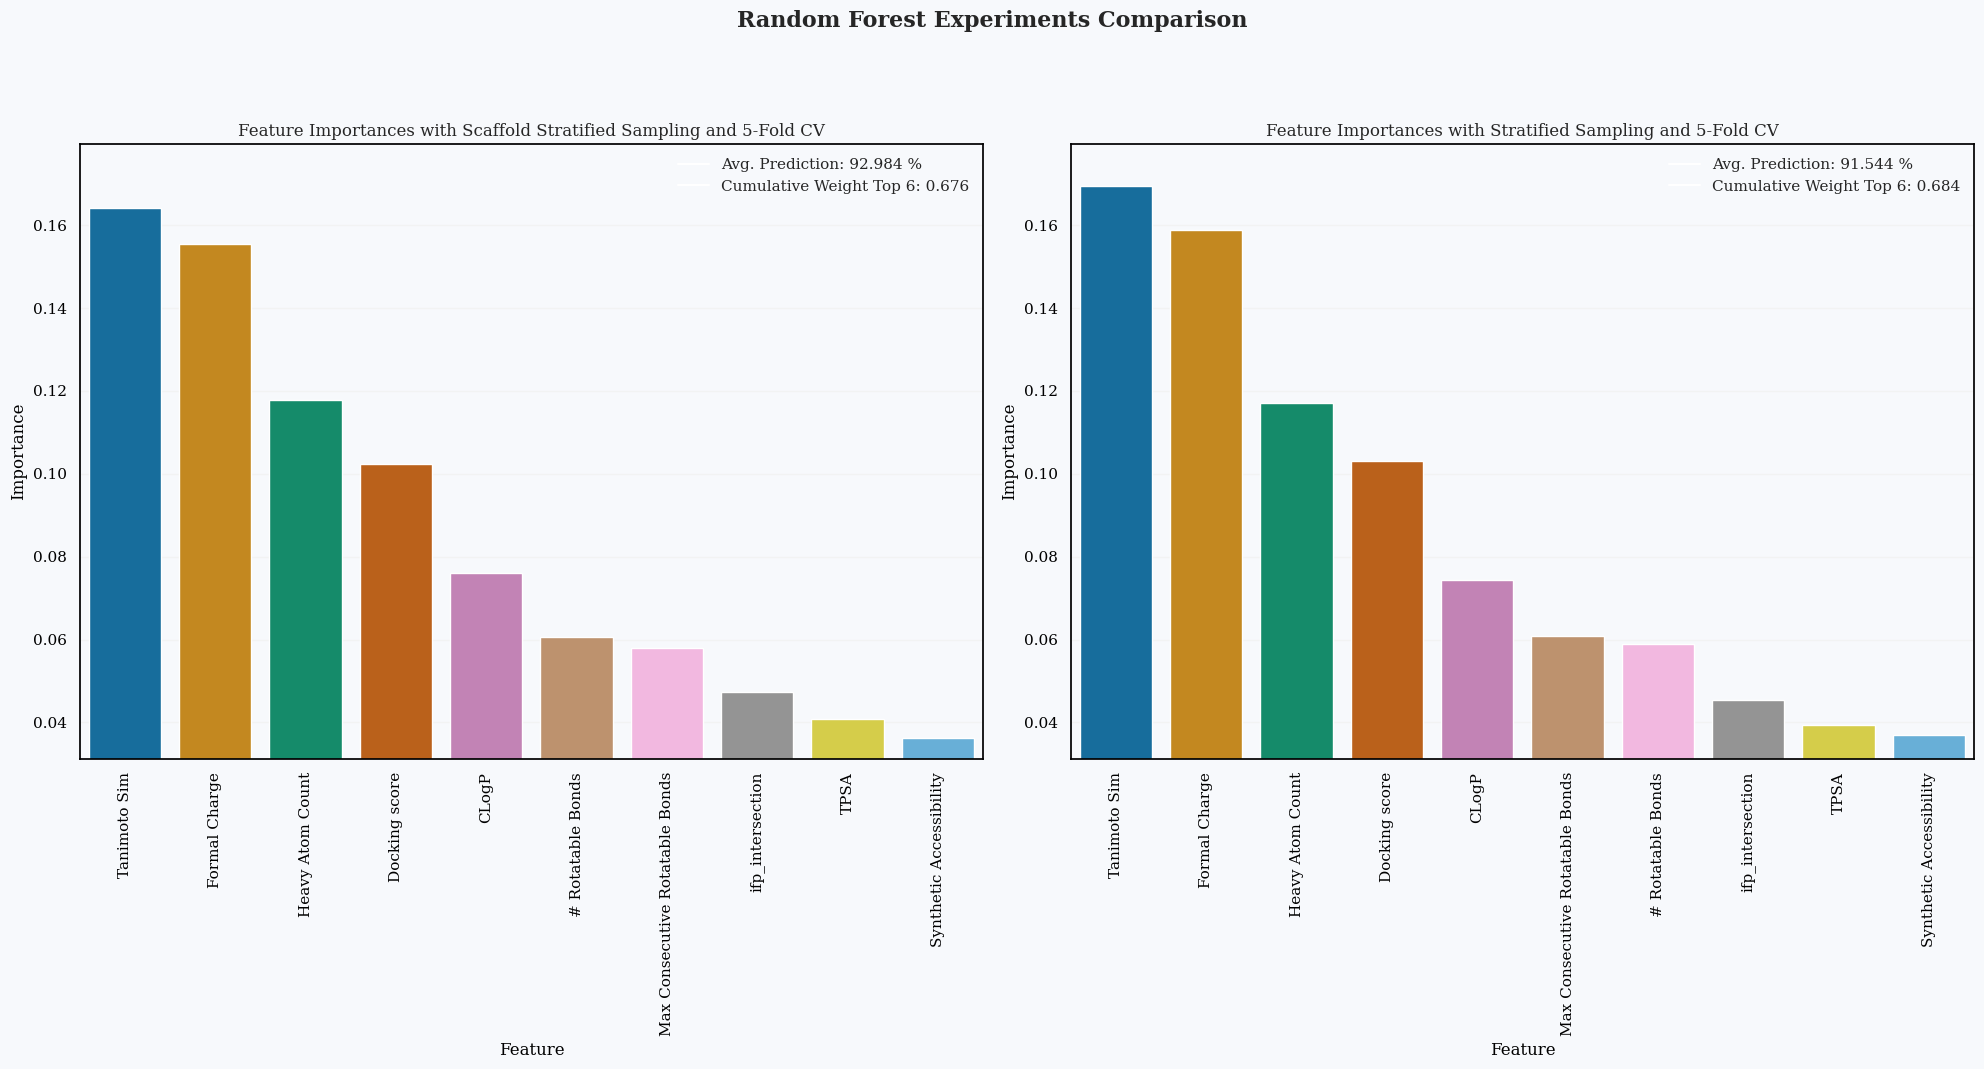

In [ ]:
from matplotlib.lines import Line2D
# List of dataframes and titles
dataframes = [feature_importance_scaffold, feature_importance_strat]
average_prediction = [average_pred_scaffold , average_pred_strat]
top_6_explain = [importance_explained_rf_scaffold, importance_explained_rf_strat]

titles = ['Feature Importances with Scaffold Stratified Sampling and 5-Fold CV',
           'Feature Importances with Stratified Sampling and 5-Fold CV']

# Calculate the max y-value for setting the same y-axis scale
max_value = max([df['Importance'].max() for df in dataframes]) + 0.01
min_value = min([df['Importance'].min() for df in dataframes]) - 0.005

# Create a figure and axis objects with subplots
fig, axs = plt.subplots(1, 2, figsize=(20, 11))
fig.suptitle('Random Forest Experiments Comparison',fontsize=16, fontweight='bold', y=1.00)

# Flatten the axes array for easy iteration
axs = axs.flatten()

# Iterate over dataframes and axes
for i, (df, title) in enumerate(zip(dataframes, titles)):
    sns.barplot(x='Feature', y='Importance', palette='colorblind', data=df, ax=axs[i])
    axs[i].set_ylim(min_value, max_value)  # Set the same y-axis scale
    axs[i].tick_params(axis='x', rotation=90)  # Rotate x-ticks
    axs[i].set_title(title)

    # Add custom legend with average prediction and cumulative weight of top 5 features
    ave_pred = average_prediction[i] * 100
    top_6_expl = top_6_explain[i]

    # Create custom legend lines
    legend_elements = [
        Line2D([0], [0], color='w', label=f'Avg. Prediction: {ave_pred:.3f} %'),
        Line2D([0], [0], color='w', label=f'Cumulative Weight Top 6: {top_6_expl:.3f}')
    ]

    # Add legend to the plot
    axs[i].legend(handles=legend_elements, loc='upper right', frameon=False)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Sensitivity Analysis with RF Correlation Analysis, Scaffold Split and 5-fold CV

The next natural question to ask is: how sensible are these results (feature's weights) with respect to the input parameters (initial distributions)

We evaluate how sensitive the feature importances and model performance are by training the model on different bootstrap samples of the data. For this analysis, we use the dataframe after correlation analysis.

In [89]:
# Extract features and target variable
X_sen_ana = X_RF_corr_analysis.copy().drop('Model', axis=1)
y = df_features['Model']

In [90]:
from sklearn.utils import resample

# Define number of bootstraps and number of splits for cross-validation
num_bootstraps = 100
num_splits = 5

# Initialize storage for feature importances and rankings
importances = np.zeros((num_bootstraps, X_sen_ana.shape[1]))
all_predictions = []

# Stratified K-Fold cross-validation
skf = StratifiedKFold(n_splits=num_splits)


In [91]:
for i in range(num_bootstraps):
    X_resample, y_resample = resample(X_sen_ana, y, random_state=i)

    fold_importances = np.zeros((num_splits, X_sen_ana.shape[1]))
    fold_predictions = []

    valid_splits = 0
    for fold_idx, (train_idx, test_idx) in enumerate(stratified_scaffold_split(X_resample, y_resample, scaffold_dict, scaffold_labels, n_splits=num_splits, random_state=42)):
        valid_splits += 1
        X_train, X_test = X_resample.iloc[train_idx], X_resample.iloc[test_idx]
        y_train, y_test = y_resample.iloc[train_idx], y_resample.iloc[test_idx]

        rf = RandomForestClassifier(n_estimators=250, max_depth=None, random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_test)
        fold_predictions.append(accuracy_score(y_test, y_pred))

        fold_importances[fold_idx, :] = rf.feature_importances_

    if valid_splits == 0:
        raise ValueError("No valid train-test splits found. Please check the splitting function.")

    importances[i, :] = np.mean(fold_importances, axis=0)
    all_predictions.append(np.mean(fold_predictions))

# Calculate mean and standard deviation of importances
mean_importances = np.mean(importances, axis=0)
std_importances = np.std(importances, axis=0)

# Calculate mean and standard deviation of predictions
mean_prediction = np.mean(all_predictions)
std_prediction = np.std(all_predictions)

print("Mean Importances:\n", mean_importances)
print("Standard Deviation of Importances:\n", std_importances)
print("Mean Prediction:\n", mean_prediction)
print("Standard Deviation of Prediction:\n", std_prediction)

Mean Importances:
 [0.07843184 0.1097193  0.02046311 0.02626522 0.03449699 0.04998121
 0.0129449  0.00318321 0.02807407 0.04063831 0.1585077  0.05461775
 0.00375717 0.1654675  0.03796205 0.0454541  0.11161197 0.01842358]
Standard Deviation of Importances:
 [0.00644847 0.00629328 0.00249623 0.00524563 0.0054748  0.0053685
 0.0027847  0.0006781  0.00446096 0.00364523 0.00935964 0.00584884
 0.00095252 0.0124159  0.00386617 0.0065367  0.01136145 0.00162312]
Mean Prediction:
 0.9624045719985097
Standard Deviation of Prediction:
 0.0071717978354181


### Visualizations

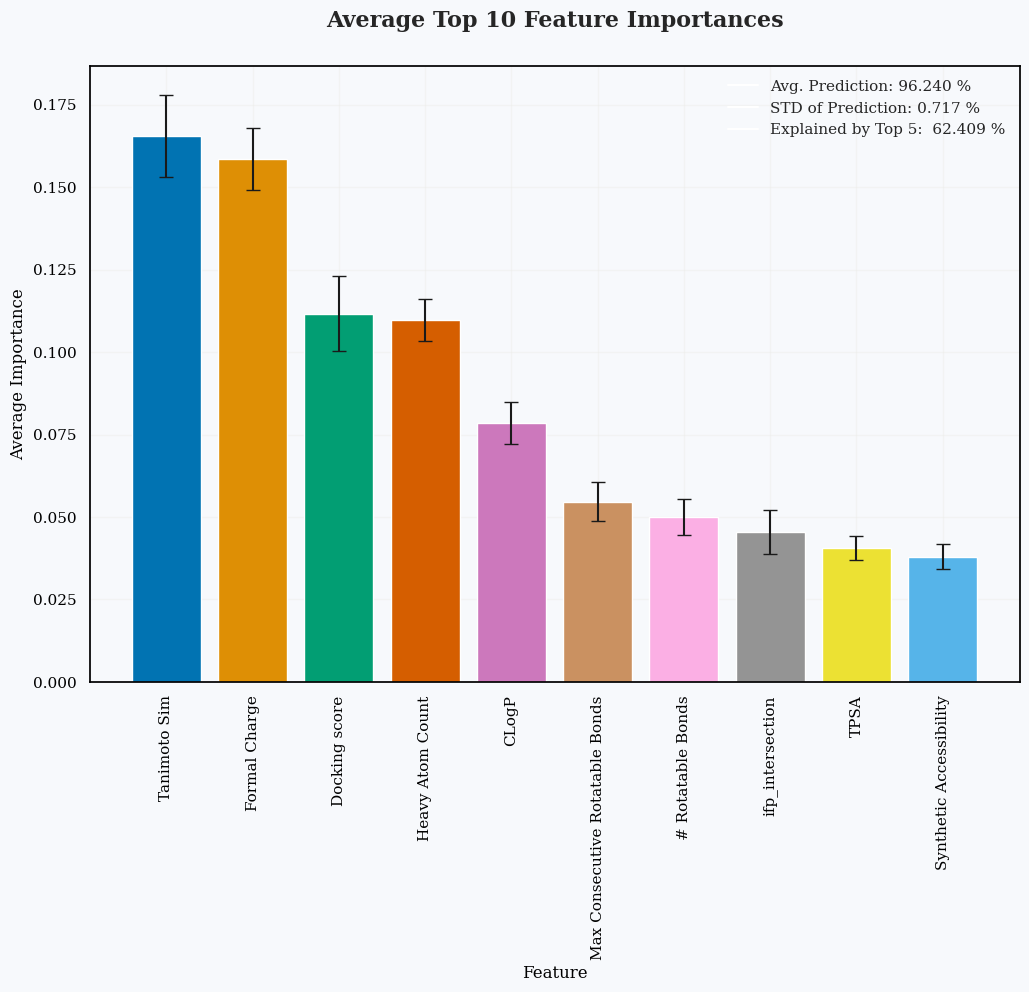

Mean Importances:
 [0.07843184 0.1097193  0.02046311 0.02626522 0.03449699 0.04998121
 0.0129449  0.00318321 0.02807407 0.04063831 0.1585077  0.05461775
 0.00375717 0.1654675  0.03796205 0.0454541  0.11161197 0.01842358]
Standard Deviation of Importances:
 [0.00644847 0.00629328 0.00249623 0.00524563 0.0054748  0.0053685
 0.0027847  0.0006781  0.00446096 0.00364523 0.00935964 0.00584884
 0.00095252 0.0124159  0.00386617 0.0065367  0.01136145 0.00162312]


In [108]:
from matplotlib.lines import Line2D
# Create a DataFrame for feature importances
feature_importance_df = pd.DataFrame({
    'Feature': X_sen_ana.columns,
    'Mean Importance': mean_importances,
    'Std Importance': std_importances
}).sort_values(by='Mean Importance', ascending=False)

# Select top 10 features
top_10_features = feature_importance_df.head(10)
# Create a figure and axis objects with subplots
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the histogram
sns.set_palette("colorblind")
bars = ax.bar(top_10_features['Feature'], top_10_features['Mean Importance'], yerr=top_10_features['Std Importance'], capsize=5, color=sns.color_palette("colorblind"))

# Add labels and title
ax.set_xlabel('Feature')
ax.set_ylabel('Average Importance')
ax.set_title('Average Top 10 Feature Importances', fontsize=16, fontweight='bold',  y=1.05)
ax.set_xticklabels(top_10_features['Feature'], rotation=90)

# Create legend elements
legend_elements = [
    Line2D([0], [0], color='w', markersize=10, label=f'Avg. Prediction: {mean_prediction*100:.3f} %' ),
    Line2D([0], [0], color='w', markersize=10, label=f'STD of Prediction: {std_prediction*100:.3f} %'),
    Line2D([0], [0], color='w', markersize=10, label=f'Explained by Top 5:  62.409 %')
]

# Add legend to the plot
ax.legend(handles=legend_elements, loc='upper right', frameon=False)

# Display the plot
plt.show()

print("Mean Importances:\n", mean_importances)
print("Standard Deviation of Importances:\n", std_importances)


In [85]:
X_RF_corr_analysis

,CLogP,Heavy Atom Count,# HAcceptors,#HDonors,# Heteroatoms,# Rotatable Bonds,# Aromatic Rings,Number Aliphatic Rings,Ring Count,TPSA,Formal Charge,Max Consecutive Rotatable Bonds,Fluorine Count,Tanimoto Sim,Synthetic Accessibility,ifp_intersection,Docking score,num_interactions,Model
0,0.569534,0.500000,0.375,0.333333,0.461538,0.3,0.4,0.000000,0.25,0.376109,1.000000,0.166667,0.75,0.424339,0.991363,0.6250,0.921212,0.40,reinvent
1,0.534803,0.461538,0.375,0.333333,0.307692,0.5,0.4,0.000000,0.25,0.376109,1.000000,0.333333,0.00,0.432447,0.953069,0.8125,0.915460,0.65,reinvent
2,0.584937,0.384615,0.375,0.000000,0.230769,0.3,0.4,0.000000,0.25,0.256475,1.000000,0.166667,0.00,0.683951,0.910879,0.5625,0.914683,0.30,reinvent
3,0.448840,0.423077,0.375,0.666667,0.307692,0.4,0.4,0.000000,0.25,0.495742,1.000000,0.166667,0.00,0.334348,0.949668,0.6875,0.899057,0.50,reinvent
4,0.572404,0.423077,0.250,0.333333,0.384615,0.2,0.4,0.000000,0.25,0.321526,1.000000,0.166667,0.75,0.433941,0.963617,0.5625,0.898631,0.40,reinvent
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
669,0.611601,0.769231,0.750,0.000000,0.461538,0.6,0.8,0.000000,0.75,0.490716,0.666667,0.500000,0.00,0.338501,0.214233,0.6250,0.215720,0.65,safe
670,0.715073,0.846154,0.500,0.000000,0.307692,0.6,0.6,0.333333,0.75,0.357422,0.666667,0.500000,0.00,0.455455,0.807231,0.7500,0.100258,0.70,safe
671,0.418177,0.730769,0.875,0.333333,0.615385,0.6,0.8,0.000000,0.75,0.738025,0.666667,0.500000,0.00,0.332482,0.375989,0.5625,0.084721,0.50,safe
672,0.825094,0.923077,0.875,0.000000,0.538462,0.7,1.0,0.000000,1.00,0.492194,0.666667,0.500000,0.00,0.230241,0.686294,0.6875,0.043557,0.70,safe


### Visualizing top distributions

Closer look at distributions of the 10 features with highest average weight

In [ ]:
std_importances[0]

0.006772107969776344

In [ ]:
# Get indices of the top 10 features
top_10_indices = np.argsort(mean_importances)[-10:][::-1]

# Extract importances and rankings for top 10 features
top_10_importances = importances[:, top_10_indices]
top_10_rankings = rankings[:, top_10_indices]

top_10_indices

array([13, 10,  1, 16,  0, 11,  5, 15,  9, 14])

In [ ]:
mean_importances
X_sen_ana.columns[13]

'Tanimoto Sim'

In [ ]:
# Determine the max x and y limits for the histograms
max_importance = np.max(top_10_importances)
max_frequency = 0

min_importance = np.min(top_10_importances)

for i in range(10):
    counts, _ = np.histogram(top_10_importances[:, i], bins=30)
    max_frequency = max(max_frequency, np.max(counts))


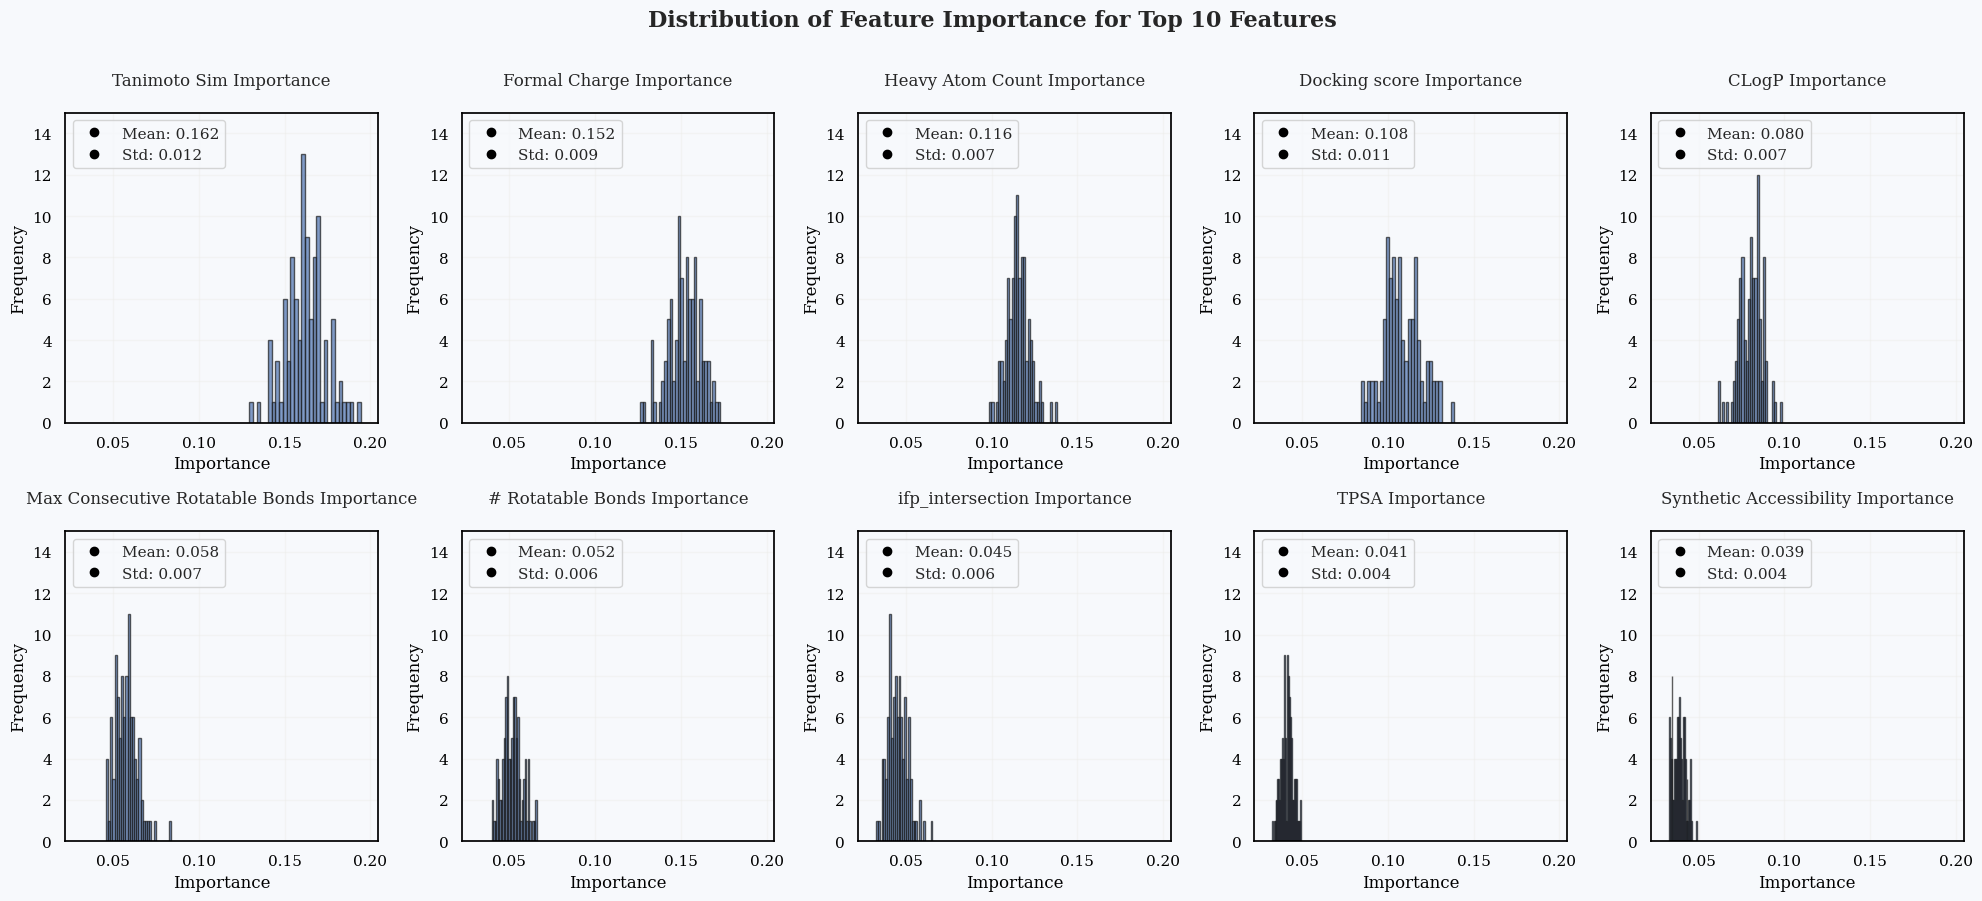

In [ ]:
from matplotlib.lines import Line2D

plt.figure(figsize=(20, 9))

for i in range(10):
    mean = mean_importances[top_10_indices[i]]
    std = std_importances[top_10_indices[i]]
    
    ax = plt.subplot(2, 5, i + 1)
    # Plot histogram
    ax.hist(top_10_importances[:, i], bins=30, edgecolor='k', alpha=0.7)
    
    # Add title and legend with custom lines and labels
    ax.set_title(f'{X_sen_ana.columns[top_10_indices[i]]} Importance', pad=20)
    ax.set_xlabel('Importance')
    ax.set_ylabel('Frequency')
    ax.set_xlim(min_importance - 0.01, max_importance + 0.01)
    ax.set_ylim(0, max_frequency + 2)

    # Create empty handles for legend
    mean_handle = Line2D([0], [0], color='none', marker='o', markerfacecolor='black', markersize=6, linestyle='None')
    std_handle = Line2D([0], [0], color='none', marker='o', markerfacecolor='black', markersize=6, linestyle='None')
    
      # Add the legend
    ax.legend(handles=[mean_handle, std_handle], labels=[
        f'Mean: {mean:.3f}', 
        f'Std: {std:.3f}'
    ], loc='upper left')

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit titles and labels
plt.suptitle('Distribution of Feature Importance for Top 10 Features', fontsize=16, fontweight='bold', y=1.00)
plt.show()

We implement Silhouette score to find the optimal subset of three features that are best at clustering the four models

# Optimal Clustering Analysis

In [ ]:
import itertools
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation

Load data for Optimal Clustering Analysis and create df with top 10 features

In [ ]:
DF_FILEPATH = f'data/animation_df.csv'
X =  pd.read_csv(DF_FILEPATH, index_col=0)


In [ ]:
df_cluster = X[['CLogP', 'Heavy Atom Count', '# Rotatable Bonds', 'Formal Charge',
        'Tanimoto Sim', 'Docking score', 'Max Consecutive Rotatable Bonds', 'ifp_intersection', 'TPSA', 'Synthetic Accessibility', 'Model']]

### Optimal Clustering Analysis

In [ ]:
le = LabelEncoder()
df_cluster['model_encoded'] = le.fit_transform(df_cluster['Model'])

In [ ]:
# Get feature columns
feature_columns = df_cluster.columns.difference(['Model', 'model_encoded'])

# Generate all combinations of three features
combinations = list(itertools.combinations(feature_columns, 3))

The following functions computes the combination of three features with the highest Silhouette Score

In [ ]:
def evaluate_feature_combinations(df, combinations):
    best_score = -1
    best_combination = None
    
    for combo in combinations:
        # Compute silhouette score
        X = df[list(combo)]
        try:
            score = silhouette_score(X, df['model_encoded'], metric='euclidean')
        except ValueError:
            score = -1  # If not enough samples per cluster

        print(f"Combination: {combo}, Silhouette Score: {score:.2f}")

        if score > best_score:
            best_score = score
            best_combination = combo
    
    return best_combination, best_score

# Evaluate combinations
best_comb, best_score = evaluate_feature_combinations(df_cluster, combinations)
print(f"Best Combination: {best_comb}, Silhouette Score: {best_score:.2f}")
